First, import the neccessary packages for this project. From there define your dataset into a dataframe.

# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Introduction:

This project consisted of obtaining a dataset of house sales from King County in Washington State. From there I was tasked to develop a multi-linear regression model in order to accurately predict housing prices from this dataset. The framework behind developing this model involved following the OSEMiN Data Science Process. This process consists of 5 key steps: 

* Obtain: 
    * Extracting the data 
* Scrub: 
    * Preprocessing the data for the model 
    * Examples include normalizing the data, removing or replacing null values, or dealing with outliers
* Explore: 
    * This step tends to blend in with the "Scrub" step 
    * Check for multicollinearity, visualize and explore the data to have an understanding of how to prepare the predictors and whether any can be dropped in order to have more accurate model
    * Usually categorizing and binning the data happens after this step in order to minimize the visualizations created
* Model: 
    * The data is modeled and evaluated based on a number of parameters
    * From there, different trails are run in which the data is again scrubbed and explored to see how it can improve the model potentially
* Interpret: 
    * The results of the model are interpreted and echoed to stakeholders .
    * From here you decide if the model is satisfactory or if further steps are needed to improve 
    
In addition, 3 meaningful questions are to be addressed through the development of a model. These questions are: 

1. Does a view actually make the house price increase?
2. Does location matter the most? If not what does?
3. How much does quality of the house affect house prices? 

# 1. Obtaining Data 

Extract the data the standard way using pandas. Let's make sure that the dataset is correct by checking the first 5 rows. 

In [2]:
df=pd.read_csv('kc_house_data.csv')
dff=df.copy()
print(df.shape)
df.head()

(21597, 21)


id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

# 2. Data Scrubbing

## Dealing with Null Values

We can then begin our data scrubbing process. First evaluate the column names then evaluate the null values in each column

In [3]:
print(df.columns)
df.isna().sum()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The columns waterfront and yr_renovated have a signficant amount of null values to where further evaluation is needed. The low number of null values in the view column allow for us to simply delete rows that contain these null values. This will be done after first evaluating the other two columns. First let's look and see the unique values for waterfront.

In [4]:
df.waterfront.unique()

array([nan,  0.,  1.])

This seems to indicate that either the property is facing the waterfront, not facing, or there is a null value. To evaluate how one can designate the null values, the price of these properties with respect to the 3 waterfront values is analyzed using a boxplot.

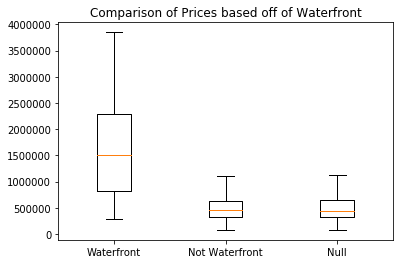

In [5]:
yes=df.price[df['waterfront']==1]
no=df.price[df['waterfront']==0]
maybe=df.price[df['waterfront'].isna()]
plt.boxplot([yes,no,maybe],labels=['Waterfront','Not Waterfront', 'Null'],showfliers=False)
plt.title('Comparison of Prices based off of Waterfront')
plt.show()

Waterfront seems to cause an increase in price but this would have to be further evaluated later within the model. More importantly for now, it seems that when the waterfront value is null it most resembles when the property is not waterfront. Thus these NaN values can be replace with 0.

In [6]:
df.waterfront.fillna(0,inplace=True)
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The focus then shifts to yr_renovated where we repeat the same process of evaluating how we can change the NaN values

In [7]:
df.yr_renovated.value_counts()


0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

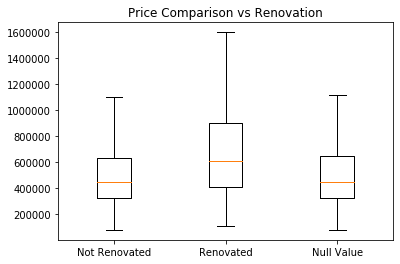

In [8]:
not_renovated=df.price[df['yr_renovated']==0]
renovated=df.price[(df['yr_renovated']!=0) &(df['yr_renovated'].notna())]
null_ren=df.price[df['yr_renovated'].isna()]
plt.boxplot([not_renovated,renovated,null_ren],labels=['Not Renovated','Renovated','Null Value'],showfliers=False)
plt.title('Price Comparison vs Renovation')
plt.show()

The same conclusions can be drawn in which all the null values are replaces with 0 as they seem to exhibit similar behavior.

In [9]:
df.yr_renovated.fillna(0,inplace=True)
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
dtype: int64

There are remaining 63 null values in the view column. Let's first see the unique values in the view column and then create a boxplot of view with respect to price based off those unique values.

In [10]:
df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

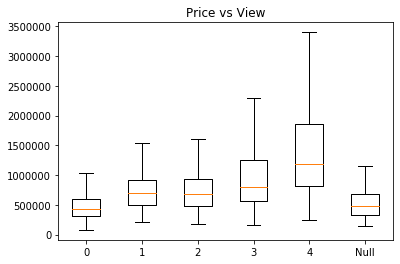

In [11]:
zero=df.price[df['view']==0]
one=df.price[df['view']==1]
two=df.price[df['view']==2]
three=df.price[df['view']==3]
four=df.price[df['view']==4]
null_view=df.price[df['view'].isna()]
plt.boxplot([zero,one,two,three,four,null_view],labels=['0','1','2','3','4','Null'],showfliers=False)
plt.title('Price vs View')
plt.show()

It seems as though the null values can be replaced for 0. Let's next check the object type of every column to see if there's anything unexpected. 

In [12]:
df.view.fillna(0,inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None


It seems as though the variable "sqft_basement" is listed as an object type. This needs to be changed to float type or integer in order to perform then necessary analysis.

In [13]:
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

There seems to be some values listed as '?'. The choice here is to replace these values via a statstical or logical reason or drop them as they only account for 2%. However, based of the column name descriptions it is possible that sqft_basement = sqft_living - sqft_above. Thus, lets first see if this holds true at first glance.

In [14]:
df.loc[:,['sqft_living','sqft_above','sqft_basement']]

sqft_living  sqft_above sqft_basement
0             1180        1180           0.0
1             2570        2170         400.0
2              770         770           0.0
3             1960        1050         910.0
4             1680        1680           0.0
...            ...         ...           ...
21592         1530        1530           0.0
21593         2310        2310           0.0
21594         1020        1020           0.0
21595         1600        1600           0.0
21596         1020        1020           0.0

[21597 rows x 3 columns]

It seems as though this might be the case thus lets find out via a boolean comparison. First we should ensure that the dtype for all columns are the same and we have to drop the '?' as this would error. 

In [15]:
test_df=df.copy()
test_df=test_df[test_df.sqft_basement!='?']
test_df.shape
test_df.sqft_basement[test_df.sqft_basement=='0.0']=0
test_df.sqft_basement=test_df.sqft_basement.astype(float)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
id               21143 non-null int64
date             21143 non-null object
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       21143 non-null float64
view             21143 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     21143 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


In [16]:
(test_df.sqft_basement!=test_df.sqft_living-test_df.sqft_above).sum()

0

Thus we can conclude that any row with a value of '?' in the sqft_basement column can be replaced by using the data from sqft_living and sqft_above. 

In [17]:
difference= (df.loc[df["sqft_basement"]=='?', ["sqft_living"]
                   ]).values-(df.loc[df["sqft_basement"]=='?', ["sqft_above"]]).values
df.loc[df["sqft_basement"]=='?', ["sqft_basement"]]=difference

In [18]:
df.sqft_basement=df.sqft_basement.astype(float)
df.sqft_basement=df.sqft_basement.astype('int64')

Next, we can see that the column 'id' is not a object type thus this needs to be changed as these values have no actual statistical value but rather are simply for the means of identification. 

In [19]:
df.id=df.id.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null object
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


It seems as though, the column data is not a datetime dtype. 

In [20]:
df['date'] = df['date'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null object
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

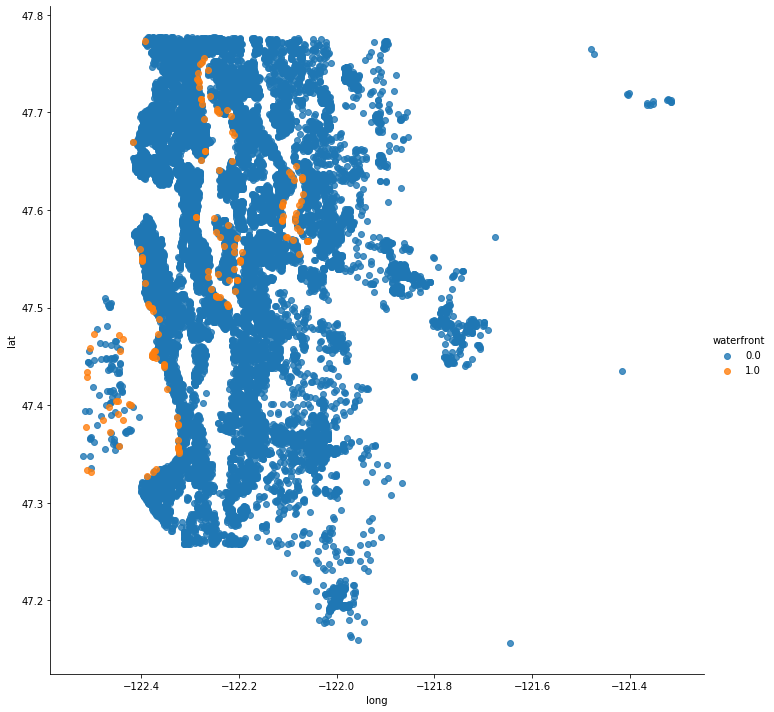

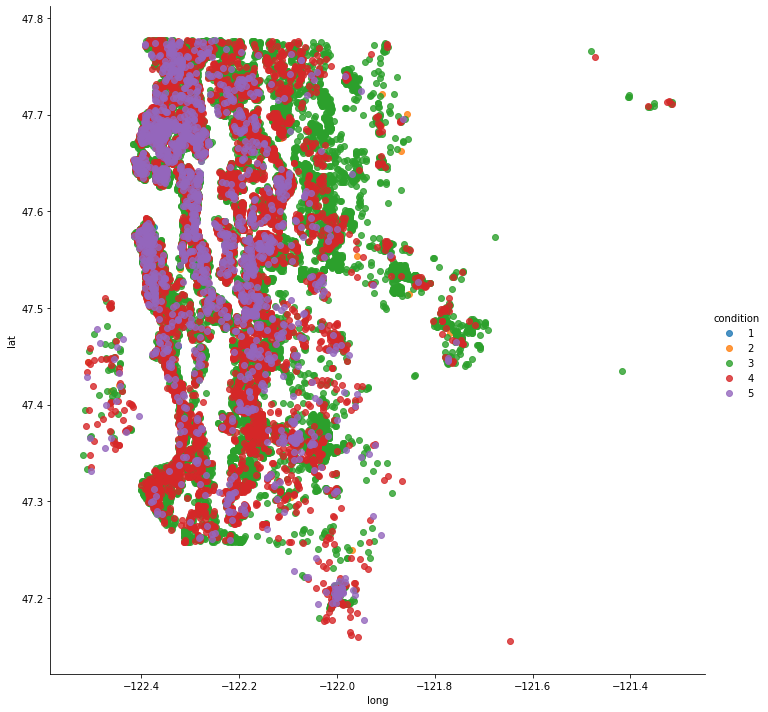

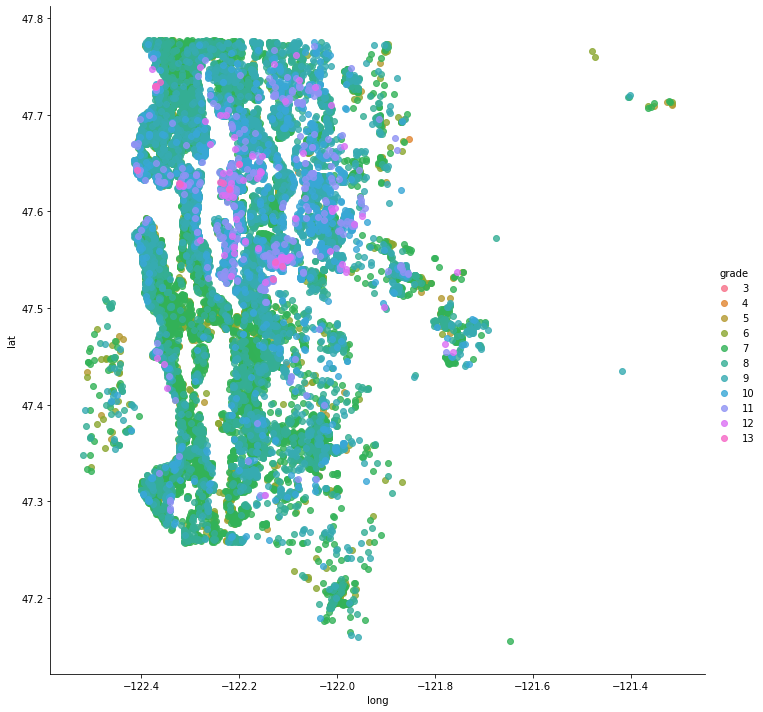

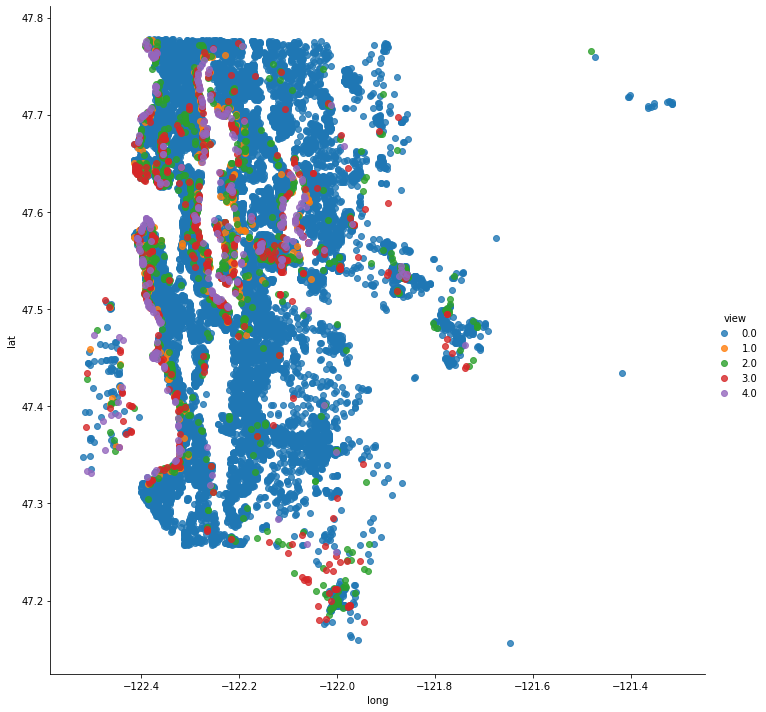

In [21]:
for col in ['waterfront','condition','grade','view']:
    g = sns.lmplot(data=df,x='long',y='lat',hue=col,height=10,fit_reg=False)

pd.plotting.scatter_matrix(df,figsize=(25,15))
plt.show()

In [22]:
#this DataFrame copy is made for Modeling Trial 3.
df3=df.copy()

# 3. Exploratory Data Analysis

This section of the project consists of preparing the data in a way that will ensure an accurate and well-performing model. First, let's observe the statistical features of the predictors and the target variable. From there we can observe the distribution of each variable to see if any further manipulation of data is necessary. 

In [23]:
df.describe()


price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  2.159700e+04   
mean   5.402966e+05      3.373200      2.115826   2080.321850  1.509941e+04   
std    3.673681e+05      0.926299      0.768984    918.106125  4.141264e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068500e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21597.000000  21597.000000  21597.000000  21597.000000  21597.000000   
mean       1.494096      0.006760      0.233181      3.409825      7.657915   
std        0.539683      0.081944      0.764673      0.650546      1.173200   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  21597.000000   21597.000000  21597.000000  21597.000000  21597.000000   
mean    1788.596842     291.725008   1970.999676     68.758207  98077.951845   
std      827.759761     442.667800     29.375234    364.037499     53.513072   
min      370.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1190.000000       0.000000   1951.000000      0.000000  98033.000000   
50%     1560.000000       0.000000   1975.000000      0.000000  98065.000000   
75%     2210.000000     560.000000   1997.000000      0.000000  98118.000000   
max     9410.000000    4820.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

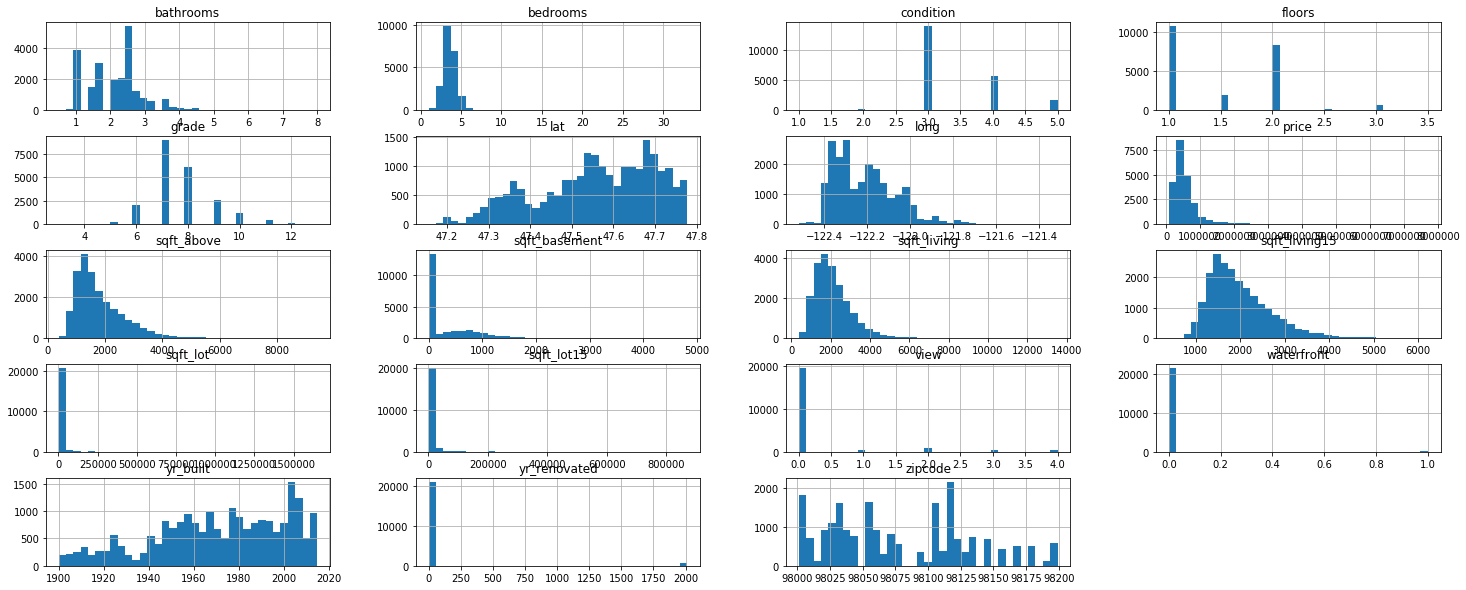

In [24]:
df.hist(figsize=(25,10),bins=35)
plt.show()

The histograms above give us a lot of information as to what needs to be done in order to have a good model as one would like for all these variables to follow a normal distribution. This however is not the case which causes the need for some variables to be dropped, categorized, or transformed. Thus, let's first examine zipcode to see which zipcodes have the highest price and if there's a clear grouping that can be made.

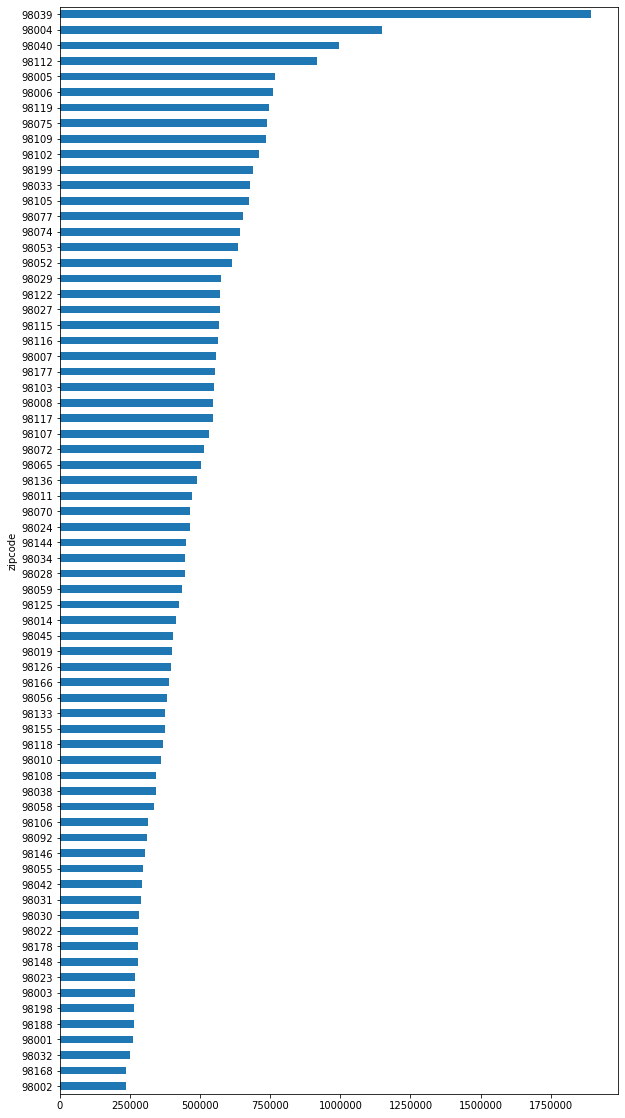

In [25]:
df.groupby('zipcode')['price'].median().sort_values().plot(kind='barh',figsize=(10,20))
plt.show()

Based off the bar graph there seems to be 4 zipcodes that differentiate themselves in terms of highest price. Let's see where these top 4 groups are and if they are near each other. 

In [26]:
df['prime_zipcode'] = df['zipcode'].isin([98039, 98004, 98040, 98112])

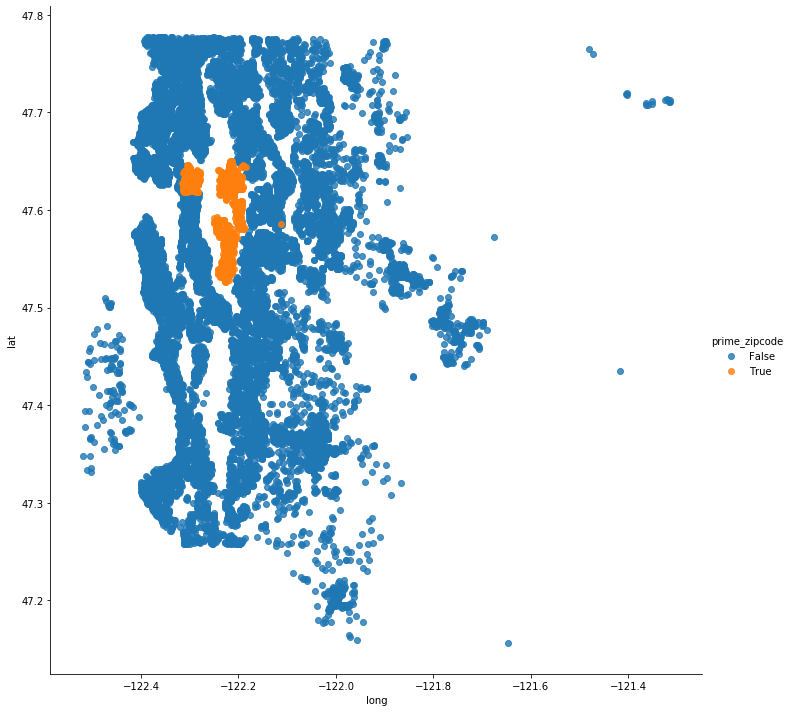

In [27]:
g = sns.lmplot(data=df,x='long',y='lat',hue='prime_zipcode',height=10,fit_reg=False)

It looks like these top 4 zipcodes are near. It also looks like the next two highest median price values with respect to zipcode are near these top 4 zipcodes. Thus it's suspected that being closer to these zipcodes would lead to an increase in prices as this grouping of top zipcodes with respect to price seems to indicate that location may be a key predictor in price. To investigate this, we'll add a variable called "dist_from_top" that consists of the distance from the average coordinates of the top 4 zipcodes. Let's first find out the average coordinates of the top 4 zipcodes. 

In [28]:
prime=df['zipcode'].isin([98039, 98004, 98040, 98112])
coordinates=[df[prime].lat.mean(),df[prime].long.mean()]
print(coordinates)

[47.60333997821352, -122.2401579520698]


We'll now introduce a function called dist_calc that will calculate the distance of every house from the average coordinates an introduce this variable into the DataFrame.

In [29]:
import math

# Radius of Earth in miles
radius=3958.8

def dist_calc(lat2,lon2):
    lat1=math.radians(coordinates[0])
    lon1=math.radians(coordinates[1])
    lat2=math.radians(lat2)
    lon2=math.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = radius * c
    return dist

In [30]:
df['dist_from_top'] = df.apply(lambda x: dist_calc(x['lat'], x['long']), axis=1)
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'prime_zipcode',
       'dist_from_top'],
      dtype='object')

This predictor variable has the potential for us to drop lat, long, and zipcode but further evaluation is needed as far as categorizing zipcode and let's first just see how the model performs with latitude and longitude in the DataFrame.

## Multicollinearity

Now that we have introduced a new variable , the next point of focus is to check for multicollinearity using the seaborn package.


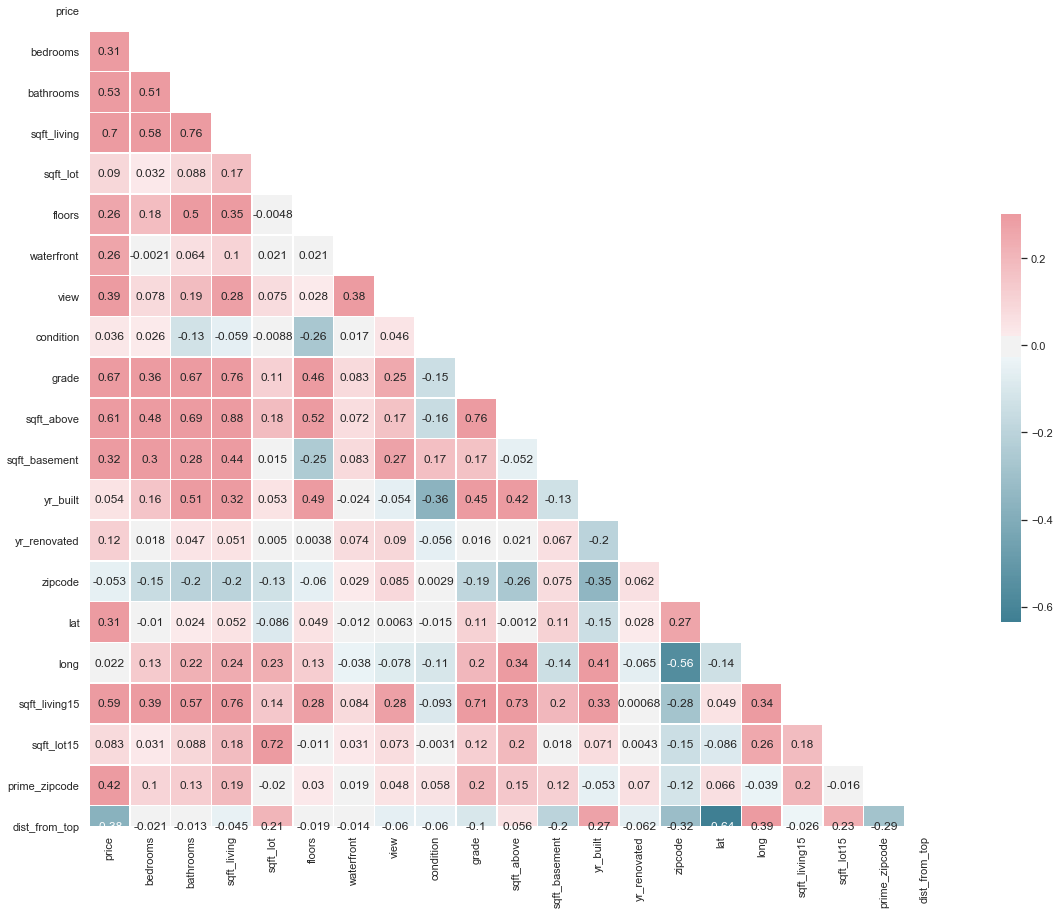

In [31]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Let's see which predictors have a correlation of over 0.75 and how many times this happens. 

In [32]:
(abs(df.corr())>.75).sum()-1

price            0
bedrooms         0
bathrooms        1
sqft_living      4
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            2
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    1
sqft_lot15       0
prime_zipcode    0
dist_from_top    0
dtype: int64

With a cutoff of 0.75 the following variables have a high correlation:

* sqft_living and sqft_living15 with correlation value of .756
* sqft_living and bathrooms with correlation value of .756
* sqft_living and sqft_above with correlation value of .876
* sqft_living and grade with correlation value of .762
* sqft_above and grade with correlation value of .756

The column sqft_living is dropped as it seems to be the consistent parameter that causes multicollinearity.


In [33]:
df.drop(['sqft_living'],axis=1,inplace=True)

Now we can once again evaluate the heatmap to see if any new correlations above 0.75 come about. 

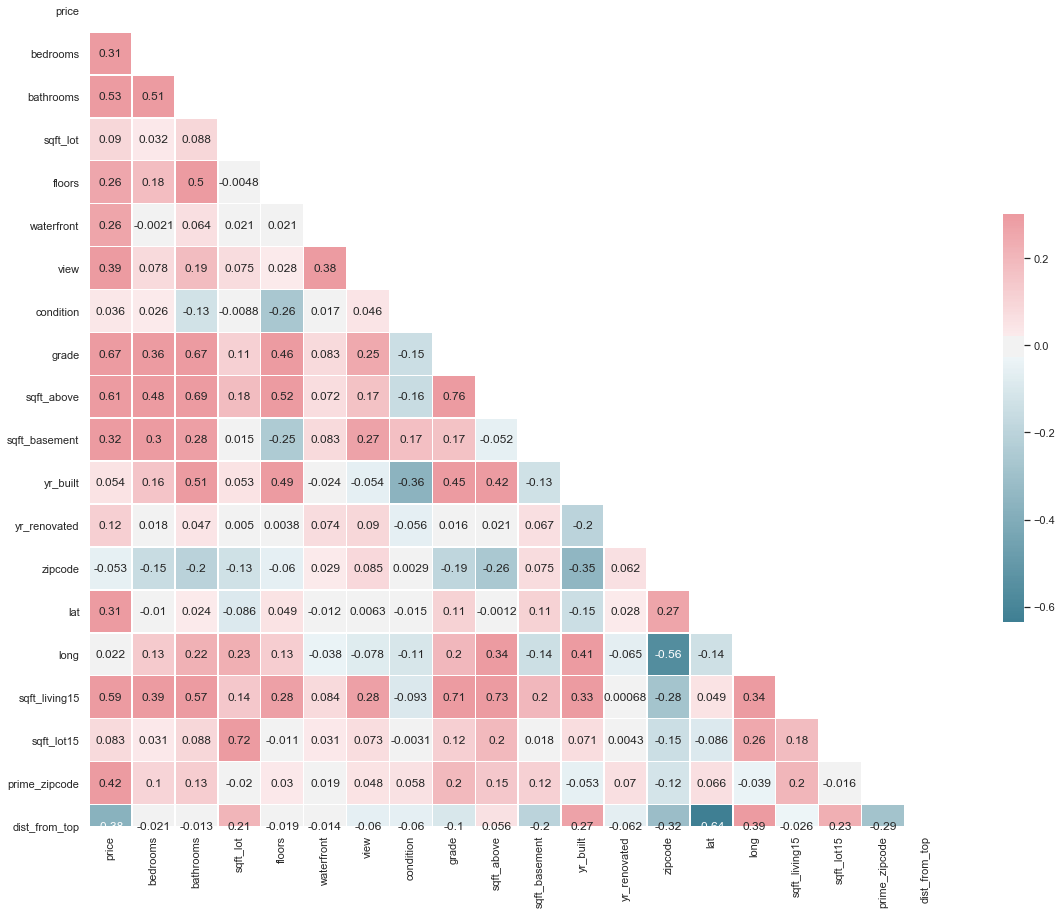

In [34]:
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [35]:
(abs(df.corr())>.75).sum()-1

price            0
bedrooms         0
bathrooms        0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            1
sqft_above       1
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
prime_zipcode    0
dist_from_top    0
dtype: int64

We can see that sqft_above and grade still have a correlation above .75. Thus further investigation is needed via a scatter plot to get an idea of this relationship. 

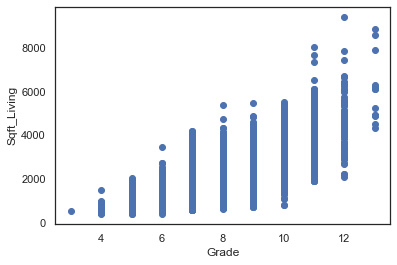

In [36]:
plt.scatter(df.grade,df.sqft_above)
plt.xlabel('Grade')
plt.ylabel('Sqft_Living')
plt.show()

It seems as though there is a linear relationship among these predictors. However, because it seems as though grade can become a categorical variable, let's wait and first develop our categorical predictors and then evaluate the multicollinearity once again.

## Categorical Variable Designation/Further Data Cleaning

After review of the histograms it is determined the following are potential categorical variables:

* bedroom
* bathroom 
* waterfront
* view 
* condition     
* zipcode
* grade
* floors 
* yr_renovated
* yr_built

It was decided that for now the variables that require dummy variable creation in order to properly categorize them are: 

* condition
* view
* waterfront
* grade
* yr_renovated
* yr_built

However, some binning is necessary to  minimize the amount of predictors in the model. After viewing the boxplots for view and waterfront, it is determined that binning is not necessary as each value for view and waterfront has its own unique price range. The first categorical variable that will be binned is condition. Let's first examine the boxplot for price with respect to condition. 


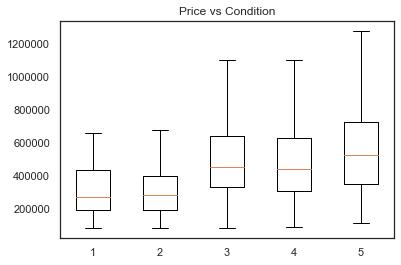

In [37]:
one=df.price[df['condition']==1]
two=df.price[df['condition']==2]
three=df.price[df['condition']==3]
four=df.price[df['condition']==4]
five=df.price[df['condition']==5]
plt.boxplot([one,two,three,four,five],labels=['1','2','3','4','5'],showfliers=False)
plt.title('Price vs Condition')
plt.show()

It looks like the data presents itself in a way to where 2 bins can be constructed where the first bin is [ 1 , 2 ] and the second bin is ( 2 , 5 ]. The next variable that is binned is yr_built. First let's view the distribution of this variable.

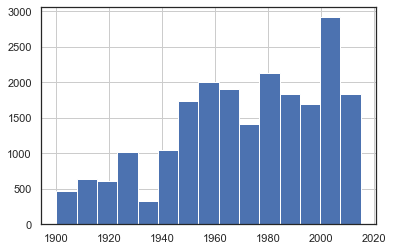

In [38]:
df.yr_built.hist(bins=15)
plt.show()

The information gained from this histogram will be taken into account in addition to accounting for the 3 most significant recessions in the USA during this time span. The first recession taken into account is the Great Depression from 1929-1933. This will be its own bin and everything before the Great Depression will be its own bin as well. From there the next bin will end at the 1973 recession. The 1973 recession is then followed by two significant recession the next 10 years. Thus this period of 3 recessions is binned together. The next bin then starts at 1983 until 1990. From there the selection for the next bin spans from 1990-2000. The bin following that leads up to 2007 in which the Great Recession occurs. This period will be binned by itself from 2007-2009, and a bin from 2009 and on is created after that. The next variable to be binned is view. Let's first look at the average prices for each view value. 

In [39]:
prices={}
for i in range(0,5):
    x=df[df['view']==i].price.mean()
    prices[i]=x
print(prices)

{0: 497210.71439568896, 1: 813373.2666666667, 2: 791390.3709508881, 3: 973285.1968503937, 4: 1452465.883280757}


It looks like 3 bins can be made from [0,1), [1,4), [4,5)

In [40]:
bins_view= [-1,0,3,4]
view= pd.cut(df['view'], bins_view)
view= view.cat.as_unordered()

bins = [1899,1928,1933,1972,1982 , 1990, 2000, 2007,2009, 2020]
new_age=pd.cut(df['yr_built'], bins)
new_age = new_age.cat.as_unordered()

bins_cond=[0,2,5]
cond=pd.cut(df['condition'], bins_cond)
cond = cond.cat.as_unordered()



This economic research led to the tangent of deciding whether a separate set of categorical variables are necessary for the year the house was sold. Lets investigate this by use of a scatter plot:

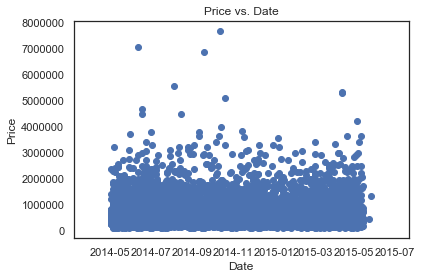

In [41]:
plt.scatter(df.date,df.price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs. Date')
plt.show()


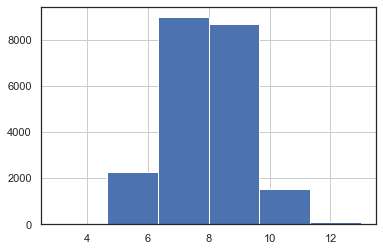

In [42]:
df.grade.hist(bins=6)
plt.show()

It seems that 3 bins for grades of 0-7, 7-9, and 9-13 is the logical choice. After further research it is found that grade represents the construction quality of improvements and they are generally defined as:

* 1-3: Falls short of minimum building standards. Normally cabin or inferior structure.

* 4: Generally older, low quality construction. Does not meet code.

* 5: Low construction costs and workmanship. Small, simple design.

* 6: Lowest grade currently meeting building code. Low quality materials and simple designs.

* 7: Average grade of construction and design. Commonly seen in plats and older sub-divisions.

* 8: Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

* 9: Better architectural design with extra interior and exterior design and quality.

* 10: Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

* 11: Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

* 12: Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

* 13: Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

Taking into account these descriptions along with the distribution of the predictor, 3 bins are created that consist of a grade of below average, average, and above average with grades of 1-6 being below average, grades 7-9 being average, and grades 10-13 being above average.

In [43]:
grade_bins=[0,6,9,13]
grade_bins=pd.cut(df['grade'], grade_bins)
grade_bins = grade_bins.cat.as_unordered()
new_grade=pd.get_dummies(grade_bins,prefix='grade')

There seems to be no real linear pattern in this data thus catergorizing seems unnecessary. After review of the histogram for yr_renovated. Further investigation is needed to see how much of the data has a value of 0 for yr_renovated.

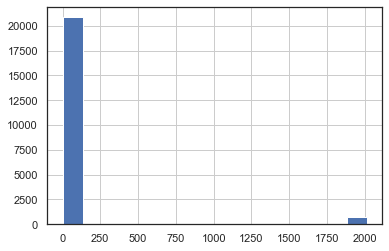

In [44]:
df.yr_renovated.hist(bins=15)

In [45]:
num_zero=(df.yr_renovated==0).sum()
print('Zero is the value for {}% of the data in the column "yr_renovated"'.format(round(num_zero/len(df)*100,2)))

Zero is the value for 96.56% of the data in the column "yr_renovated"


This is a large amount thus the variable yr_renovated can be transformed into a boolean column named "Renovated?" that simply depends on whether the house was renovated or not.

In [46]:
renovated=[]
for val in df.yr_renovated:
    if val == 0:
        renovated.append(False)
    else:
        renovated.append(True)
ren=np.array(renovated)
ren=pd.DataFrame(ren,columns=['Renovated?'])
df=pd.concat([df,ren],axis=1)

We now can create the categorical variables and incorporate them into the DataFrame. We also can drop the original columns with variables that were categorized.  

In [47]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'prime_zipcode', 'dist_from_top',
       'Renovated?'],
      dtype='object')

In [48]:
cond=pd.get_dummies(cond,prefix='condition')
view=pd.get_dummies(view,prefix='view')
waterfront=pd.get_dummies(df['waterfront'],prefix='waterfront')
grade=pd.get_dummies(new_grade,prefix='grade')
dum_ren=pd.get_dummies(df['Renovated?'],prefix='Renovated?')
new_age=pd.get_dummies(new_age,prefix='yr_built')
prime_zip=pd.get_dummies(df['prime_zipcode'],prefix='prime_zipcode')



In [49]:

df=pd.concat([df,cond,view,waterfront,new_age,grade,dum_ren,prime_zip],axis=1)
df.drop(['condition','view','waterfront','grade','yr_built',
             'yr_renovated','Renovated?','prime_zipcode'],axis=1,inplace=True)
df.head()

id       date     price  bedrooms  bathrooms  sqft_lot  floors  \
0  7129300520 2014-10-13  221900.0         3       1.00      5650     1.0   
1  6414100192 2014-12-09  538000.0         3       2.25      7242     2.0   
2  5631500400 2015-02-25  180000.0         2       1.00     10000     1.0   
3  2487200875 2014-12-09  604000.0         4       3.00      5000     1.0   
4  1954400510 2015-02-18  510000.0         3       2.00      8080     1.0   

   sqft_above  sqft_basement  zipcode  ...  yr_built_(2000, 2007]  \
0        1180              0    98178  ...                      0   
1        2170            400    98125  ...                      0   
2         770              0    98028  ...                      0   
3        1050            910    98136  ...                      0   
4        1680              0    98074  ...                      0   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  grade_(0, 6]  grade_(6, 9]  \
0                      0                      0             0             1   
1                      0                      0             0             1   
2                      0                      0             1             0   
3                      0                      0             0             1   
4                      0                      0             0             1   

   grade_(9, 13]  Renovated?_False  Renovated?_True  prime_zipcode_False  \
0              0                 1                0                    1   
1              0                 0                1                    1   
2              0                 1                0                    1   
3              0                 1                0                    1   
4              0                 1                0                    1   

   prime_zipcode_True  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 38 columns]

In [50]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'dist_from_top', 'condition_(0, 2]',
       'condition_(2, 5]', 'view_(-1, 0]', 'view_(0, 3]', 'view_(3, 4]',
       'waterfront_0.0', 'waterfront_1.0', 'yr_built_(1899, 1928]',
       'yr_built_(1928, 1933]', 'yr_built_(1933, 1972]',
       'yr_built_(1972, 1982]', 'yr_built_(1982, 1990]',
       'yr_built_(1990, 2000]', 'yr_built_(2000, 2007]',
       'yr_built_(2007, 2009]', 'yr_built_(2009, 2020]', 'grade_(0, 6]',
       'grade_(6, 9]', 'grade_(9, 13]', 'Renovated?_False', 'Renovated?_True',
       'prime_zipcode_False', 'prime_zipcode_True'],
      dtype='object')

In [51]:
df.drop(['Renovated?_False','waterfront_0.0','prime_zipcode_False','condition_(0, 2]',
        'view_(-1, 0]','grade_(0, 6]'],axis=1,inplace=True)
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'dist_from_top', 'condition_(2, 5]',
       'view_(0, 3]', 'view_(3, 4]', 'waterfront_1.0', 'yr_built_(1899, 1928]',
       'yr_built_(1928, 1933]', 'yr_built_(1933, 1972]',
       'yr_built_(1972, 1982]', 'yr_built_(1982, 1990]',
       'yr_built_(1990, 2000]', 'yr_built_(2000, 2007]',
       'yr_built_(2007, 2009]', 'yr_built_(2009, 2020]', 'grade_(6, 9]',
       'grade_(9, 13]', 'Renovated?_True', 'prime_zipcode_True'],
      dtype='object')

In [52]:
# copy made for trial 2
df2=df.copy()

## Normalization and Standardization of Data

To begin the process of normalizing data, we first should evaluate the distribution of each variable.

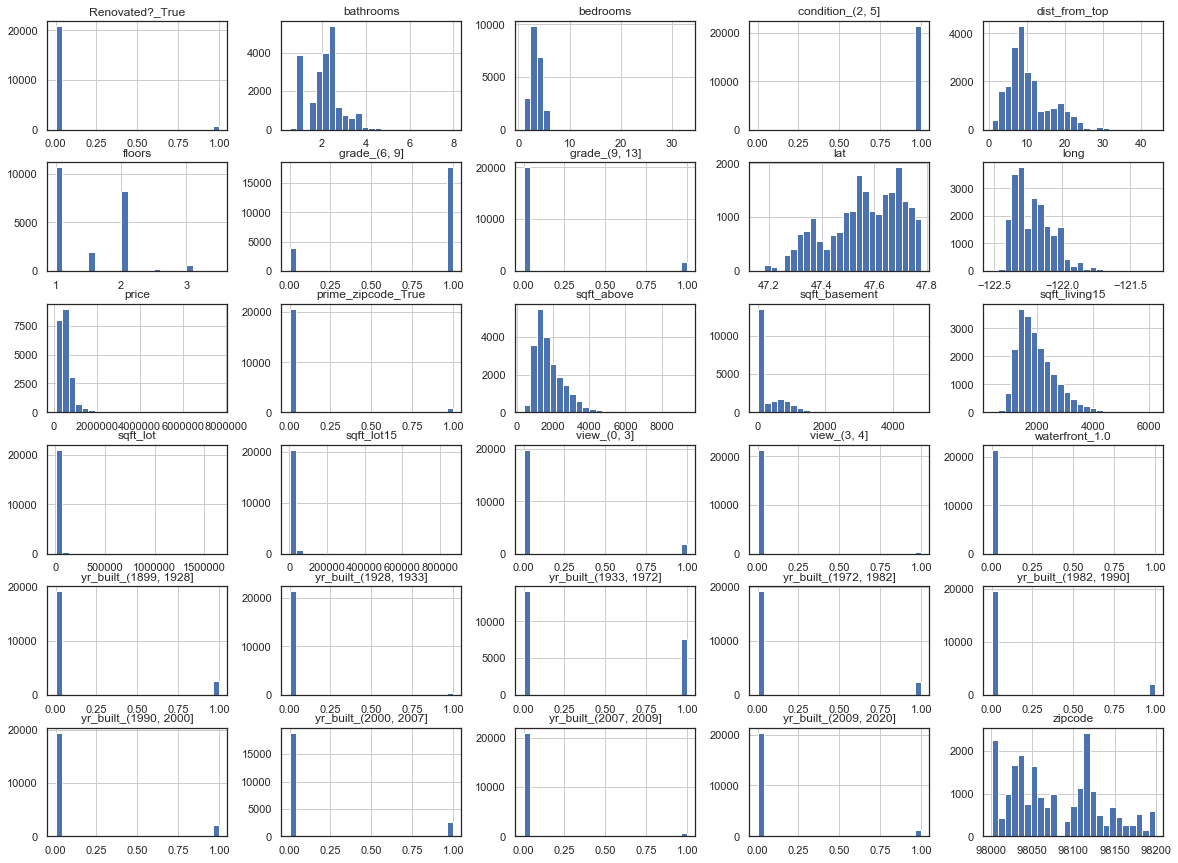

In [53]:
df.hist(figsize=[20,15],bins=25)
plt.show()

From the histograms, one can determine .......

The continuous variables to be normally distributed are:
* sqft_above
* sqft_living15
* sqft_lot
* sqft_lot15
* sqft_basement

These variables were picked in order stay sensitive to outliers. The following features were selected to be min/max scaled:

* floors
* bathrooms
* bedrooms

These variables were min/max scaled in order to scale the values of floors, bathrooms, and bedrooms from 0 to 1. This method of scaling is less senstive to outliers. Thus let's check to see if there are any extreme outliers to verify this decision being less sensitive to them

In [54]:
print('Floors min: {}\nFloors max: {}'.format(df.floors.min(),df.floors.max()))
print('Bathrooms min: {}\nBathrooms max: {}'.format(df.bathrooms.min(),df.bathrooms.max()))
print('Bedrooms min: {}\nBedrooms max: {}'.format(df.bedrooms.min(),df.bedrooms.max()))

Floors min: 1.0
Floors max: 3.5
Bathrooms min: 0.5
Bathrooms max: 8.0
Bedrooms min: 1
Bedrooms max: 33


Thus min/max scaling is selected to stay less sensitive to the extreme outlier of 33 in the bedrooms column

In [55]:
df_save = df.copy()
df.sqft_above=np.log(df.sqft_above)
df.sqft_living15=np.log(df.sqft_living15)
df.sqft_lot=np.log(df.sqft_lot)
df.price=np.log(df.price)
df.sqft_basement=np.log1p(df.sqft_basement)
df.bedrooms=np.log(df.bedrooms)
df.bathrooms=np.log(df.bathrooms)
df.dist_from_top=np.log(df.dist_from_top)


In [56]:
df.sqft_above=(df.sqft_above-df.sqft_above.mean())/df.sqft_above.std()
df.sqft_living15=(df.sqft_living15-df.sqft_living15.mean())/df.sqft_living15.std()
df.sqft_lot=(df.sqft_lot-df.sqft_lot.mean())/df.sqft_lot.std()
df.sqft_lot15=(df.sqft_lot15-df.sqft_lot15.mean())/df.sqft_lot15.std()
df.sqft_basement=(df.sqft_basement-df.sqft_basement.mean())/df.sqft_basement.std()
df.dist_from_top=(df.dist_from_top-df.dist_from_top.mean())/df.dist_from_top.std()
df.price=(df.price-df.price.mean())/df.price.std()

df.floors=(df.floors-df.floors.mean())/(df.floors.max()-df.floors.min())
df.bathrooms=(df.bathrooms-df.bathrooms.mean())/(df.bathrooms.max()-df.bathrooms.min())
df.bedrooms=(df.bedrooms-df.bedrooms.mean())/(df.bedrooms.max()-df.bedrooms.min())

After this standardization, we are almost ready to model the DataFrame but the multicollinearity should be checked one final time.

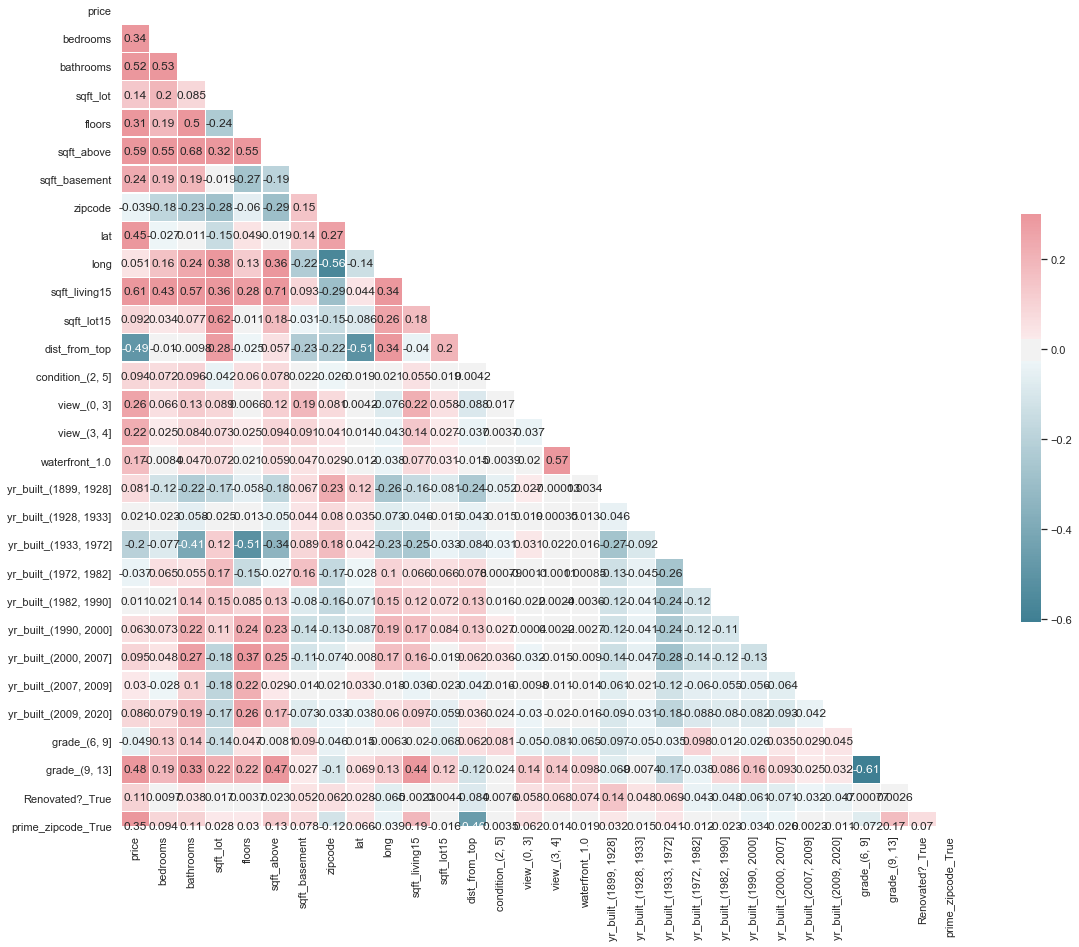

In [57]:
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [58]:
(abs(df.corr())>.7).sum()-1

price                    0
bedrooms                 0
bathrooms                0
sqft_lot                 0
floors                   0
sqft_above               1
sqft_basement            0
zipcode                  0
lat                      0
long                     0
sqft_living15            1
sqft_lot15               0
dist_from_top            0
condition_(2, 5]         0
view_(0, 3]              0
view_(3, 4]              0
waterfront_1.0           0
yr_built_(1899, 1928]    0
yr_built_(1928, 1933]    0
yr_built_(1933, 1972]    0
yr_built_(1972, 1982]    0
yr_built_(1982, 1990]    0
yr_built_(1990, 2000]    0
yr_built_(2000, 2007]    0
yr_built_(2007, 2009]    0
yr_built_(2009, 2020]    0
grade_(6, 9]             0
grade_(9, 13]            0
Renovated?_True          0
prime_zipcode_True       0
dtype: int64

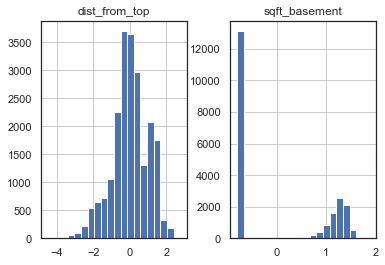

In [59]:
df.loc[:,['sqft_basement','dist_from_top']].hist(bins=20)
plt.show()

These histograms look very identical. It is decided that due variable sqft_basement will be dropped due to the following reasons: 
* It initially had a many values of zero thus causing a special transformation unlike the rest of the variables of log(1+x) for every x in the sqft_basement column
* The predictor dist_from_top is more of interest in helping to solve our questions
* 

In [60]:
#df.drop('sqft_basement',axis=1,inplace=True)

It seems that dist_from_top and sqft_basement have an correlation of over 0.75. Let's look at the distributions of each variable to see which one would affect our normality the most to where they can be dropped. 

Next, let's evaluate histograms with kde plots to better understand the distributions of the continuous variables.

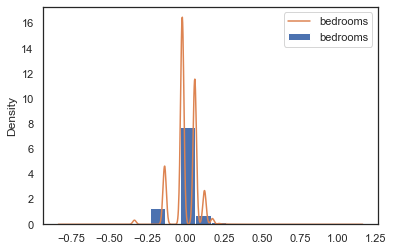

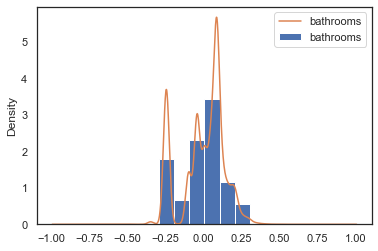

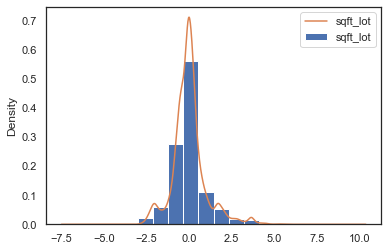

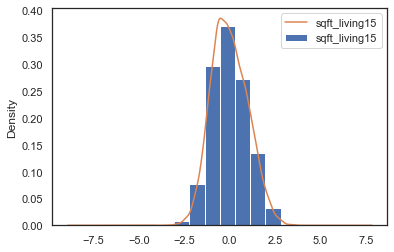

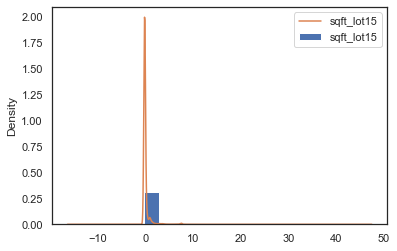

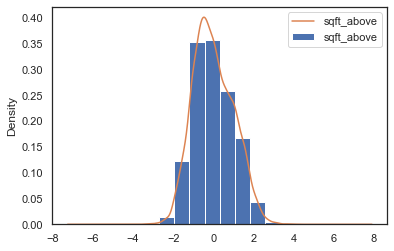

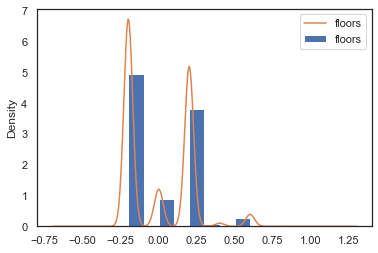

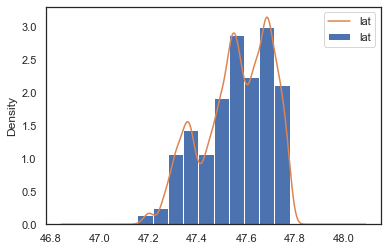

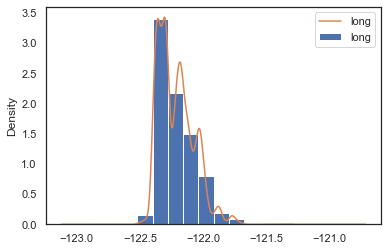

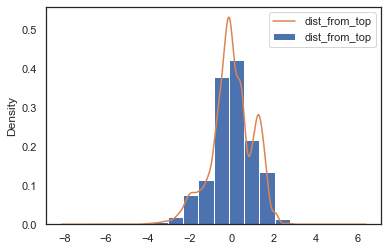

In [61]:
for col in ['bedrooms','bathrooms','sqft_lot','sqft_living15',
            'sqft_lot15','sqft_above','floors','lat','long','dist_from_top']:
    df[col].plot.hist(density=True )
    df[col].plot.kde(label=col )
    plt.legend()
    plt.show()

The continuous variables seem to follow a normal distribution for the most part. The variables that are most in question are floors, bedrooms, bathrooms, longitude, and latitude. Let's first evaluate the initial model before we decided what to do. There is potential to either normalize and standardize the longitude and latitude variables or simply drop them because of the variable dist_from_top. We'll next evaluate the linearity between each predictor and the target variable "price" in order to understand which predictors seem to show linear behavior with respect to the target variable. 

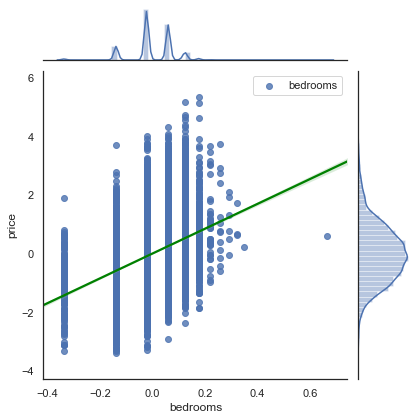

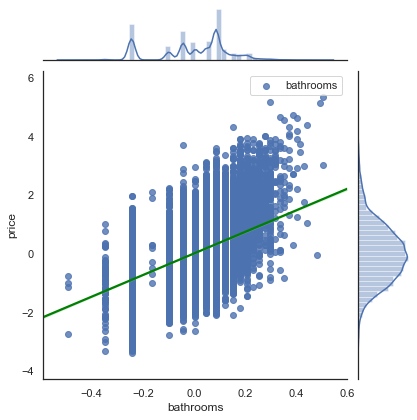

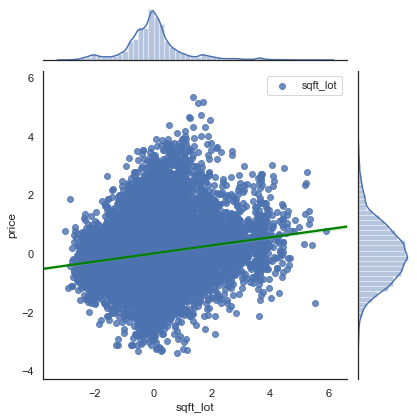

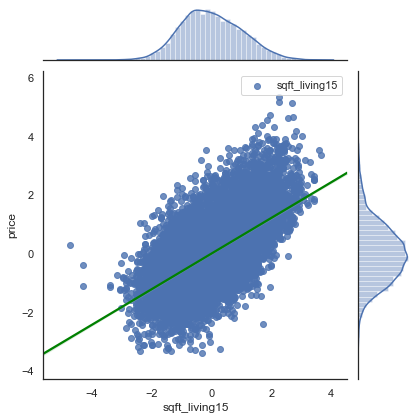

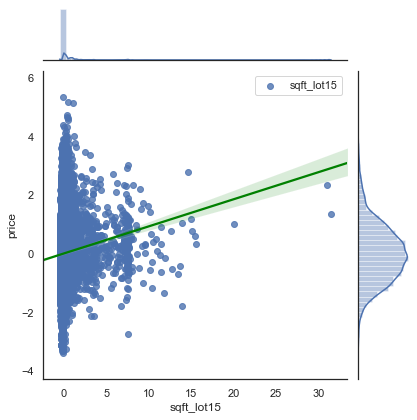

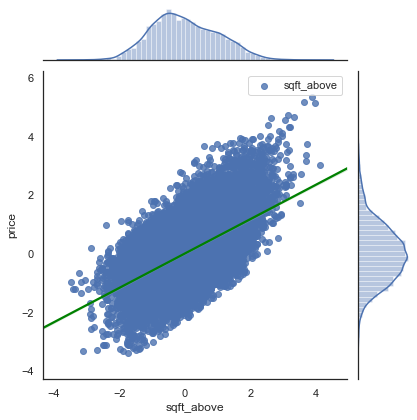

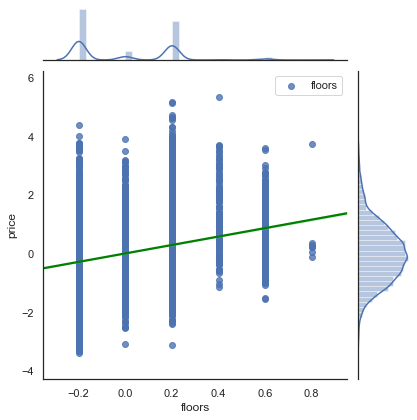

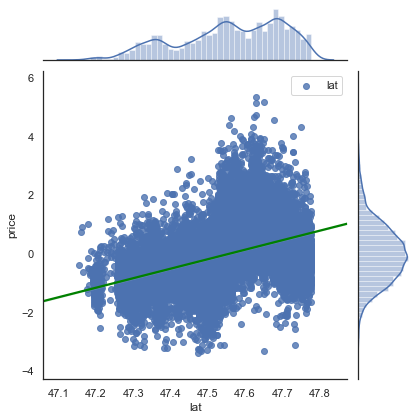

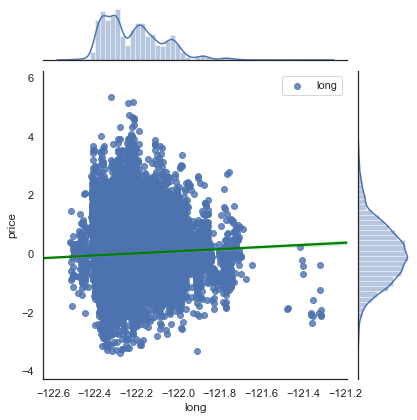

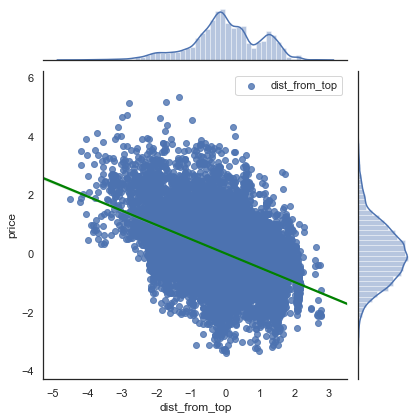

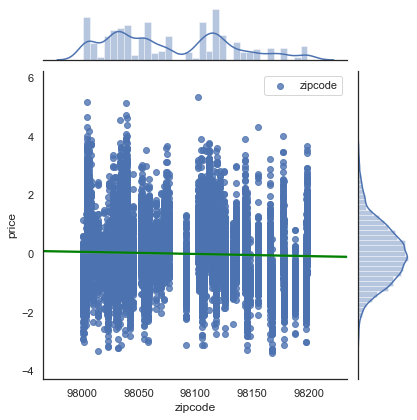

In [62]:
for col in ['bedrooms','bathrooms','sqft_lot','sqft_living15',
            'sqft_lot15','sqft_above','floors','lat','long','dist_from_top','zipcode']:
    sns.jointplot(x=col, y="price",
                  data=df, 
                  kind='reg', 
                  label=col,
                  joint_kws={'line_kws':{'color':'green'}})
#     sns.regplot(walmart[column], walmart.Weekly_Sales, label=column)
    plt.legend()
    plt.show()

The variables longitude, floors, zipcode, and sqft_lot show a slight linear relationship to price thus there is potential for these variables to be dropped in the final model. 

# 4. Modeling 

To start the modeling process, let's drop the columns id and date as they present to value to the model. 

In [63]:
df.drop(['id','date'],axis=1,inplace=True)

## Trial 1: Initial Model

* Categorical predictors: view (binned), waterfront, grade, condition (binned), yr_built (binned), Renovated?, zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_living15, sqft_living, dist_from_top
* Notes: initial model

In [64]:
df.head()
df.columns 

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'dist_from_top', 'condition_(2, 5]', 'view_(0, 3]',
       'view_(3, 4]', 'waterfront_1.0', 'yr_built_(1899, 1928]',
       'yr_built_(1928, 1933]', 'yr_built_(1933, 1972]',
       'yr_built_(1972, 1982]', 'yr_built_(1982, 1990]',
       'yr_built_(1990, 2000]', 'yr_built_(2000, 2007]',
       'yr_built_(2007, 2009]', 'yr_built_(2009, 2020]', 'grade_(6, 9]',
       'grade_(9, 13]', 'Renovated?_True', 'prime_zipcode_True'],
      dtype='object')

In [65]:
testing=df.copy()
#testing.drop(new_age,axis=1,inplace=True)
#testing.drop(['long','lat','floors',''],axis=1,inplace=True)
x=testing.drop(['price','yr_built_(1899, 1928]'],axis=1)
y=testing.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [66]:
x_train.shape

(17277, 28)

In [67]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2592.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:06:29   Log-Likelihood:                -10287.
No. Observations:               17277   AIC:                         2.063e+04
Df Residuals:                   17248   BIC:                         2.086e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -40.7245      7.307     -5.574      0.000     -55.046     -26.403
bedrooms                 -0.6570      0.056    -11.644      0.000      -0.768      -0.546
bathrooms                 0.5436      0.043     12.541      0.000       0.459       0.629
sqft_lot                  0.0634      0.006     10.100      0.000       0.051       0.076
floors                    0.0457      0.026      1.751      0.080      -0.005       0.097
sqft_above                0.3809      0.008     48.477      0.000       0.365       0.396
sqft_basement             0.1550      0.005     33.041      0.000       0.146       0.164
zipcode                  -0.0006   8.24e-05     -7.383      0.000      -0.001      -0.000
lat                       2.0386      0.030     67.913      0.000       1.980       2.097
long                     -0.0247      0.033     -0.739      0.460      -0.090       0.041
sqft_living15             0.1256      0.006     22.765      0.000       0.115       0.136
sqft_lot15                0.0303      0.005      6.525      0.000       0.021       0.039
dist_from_top            -0.2548      0.005    -50.169      0.000      -0.265      -0.245
condition_(2, 5]          0.4245      0.035     12.090      0.000       0.356       0.493
view_(0, 3]               0.3431      0.013     26.365      0.000       0.318       0.369
view_(3, 4]               0.7332      0.034     21.456      0.000       0.666       0.800
waterfront_1.0            0.6667      0.050     13.460      0.000       0.570       0.764
yr_built_(1928, 1933]    -0.0638      0.028     -2.263      0.024      -0.119      -0.009
yr_built_(1933, 1972]    -0.3373      0.012    -27.913      0.000      -0.361      -0.314
yr_built_(1972, 1982]    -0.4298      0.016    -27.371      0.000      -0.461      -0.399
yr_built_(1982, 1990]    -0.3874      0.017    -22.545      0.000      -0.421      -0.354
yr_built_(1990, 2000]    -0.3364      0.018    -19.001      0.000      -0.371      -0.302
yr_built_(2000, 2007]    -0.3059      0.017    -17.617      0.000      -0.340      -0.272
yr_built_(2007, 2009]    -0.2782      0.025    -11.171      0.000      -0.327      -0.229
yr_built_(2009, 2020]    -0.1462      0.020     -7.258      0.000      -0.186      -0.107
grade_(6, 9]              0.2408      0.013     18.699      0.000       0.216       0.266
grade_(9, 13]             0.6354      0.021     29.996      0.000       0.594       0.677
Renovated?_True           0.1108      0.019      5.836      0.000       0.074       0.148
prime_zipcode_True        0.4310      0.020     21.333      0.000       0.391       0.471
==============================================================================
Omnibus:                      428.336   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarqu

In [68]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [69]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.19261806799982245
Test Mean Squarred Error: 0.20105797797874153


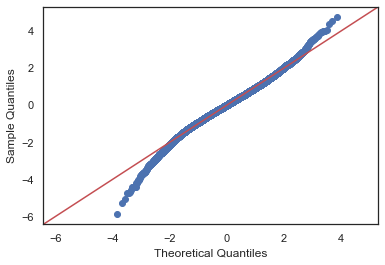

In [70]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

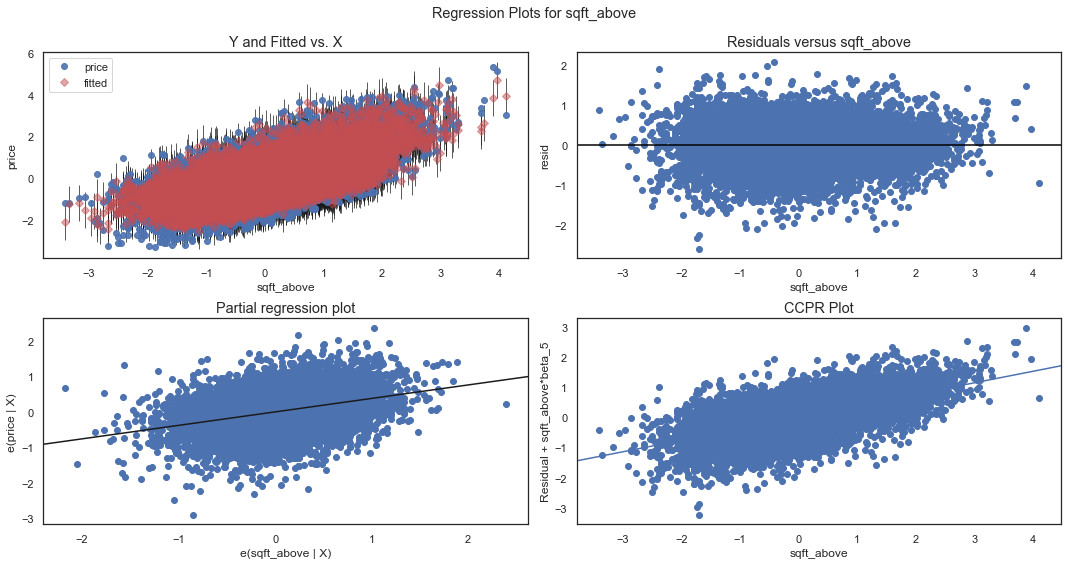

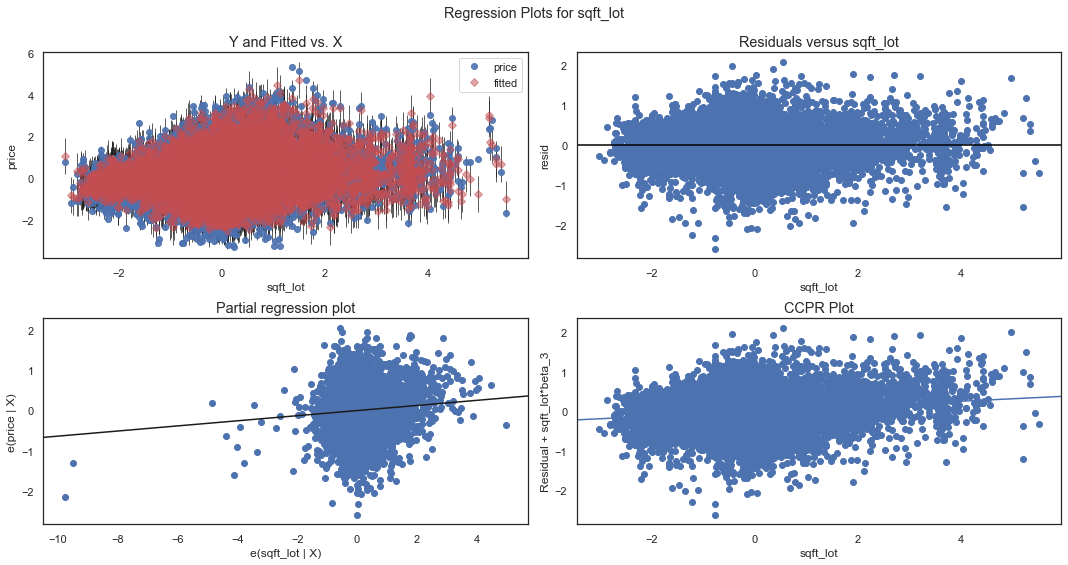

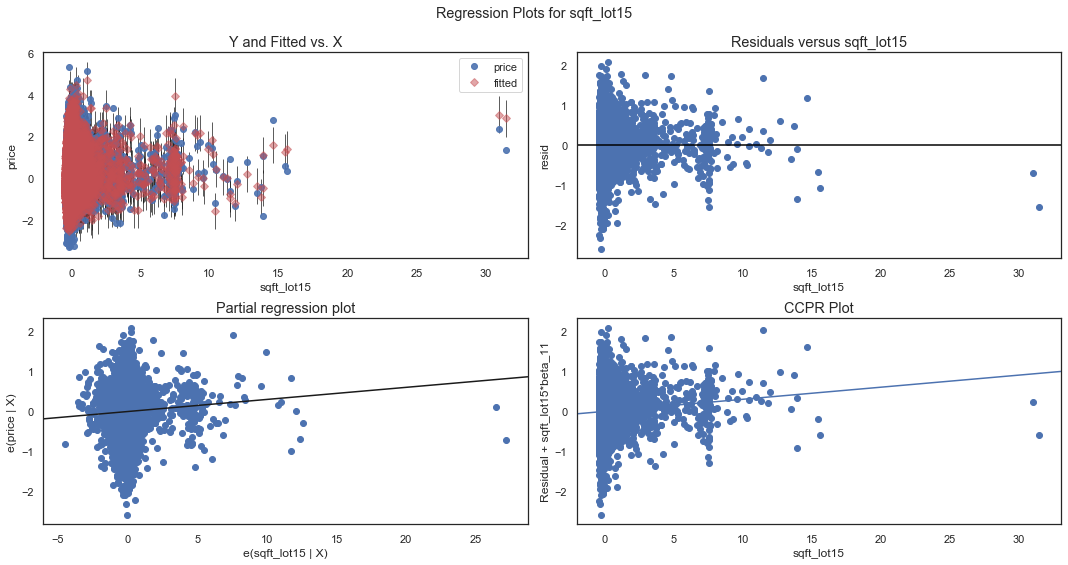

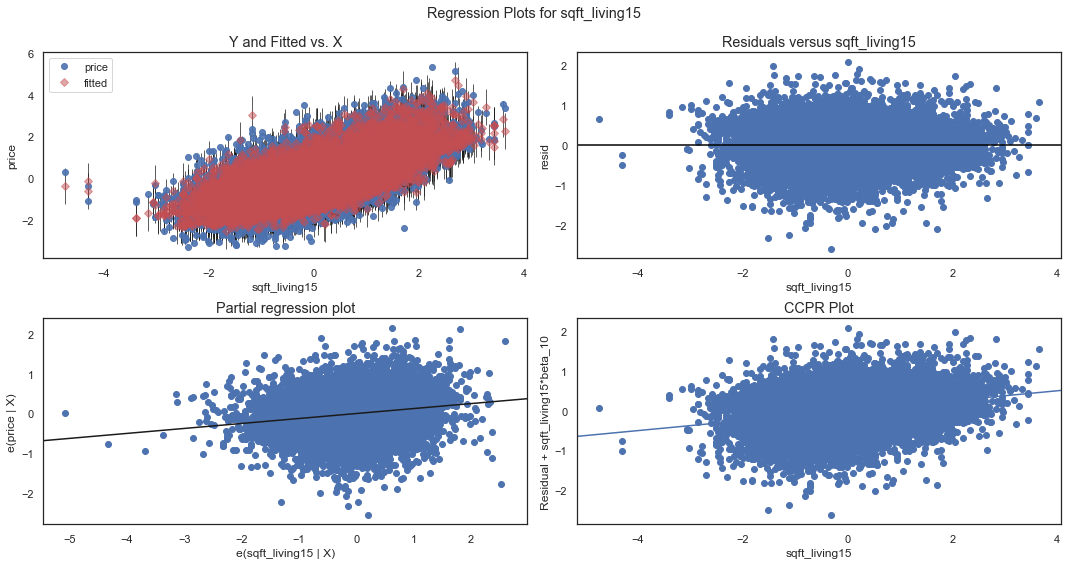

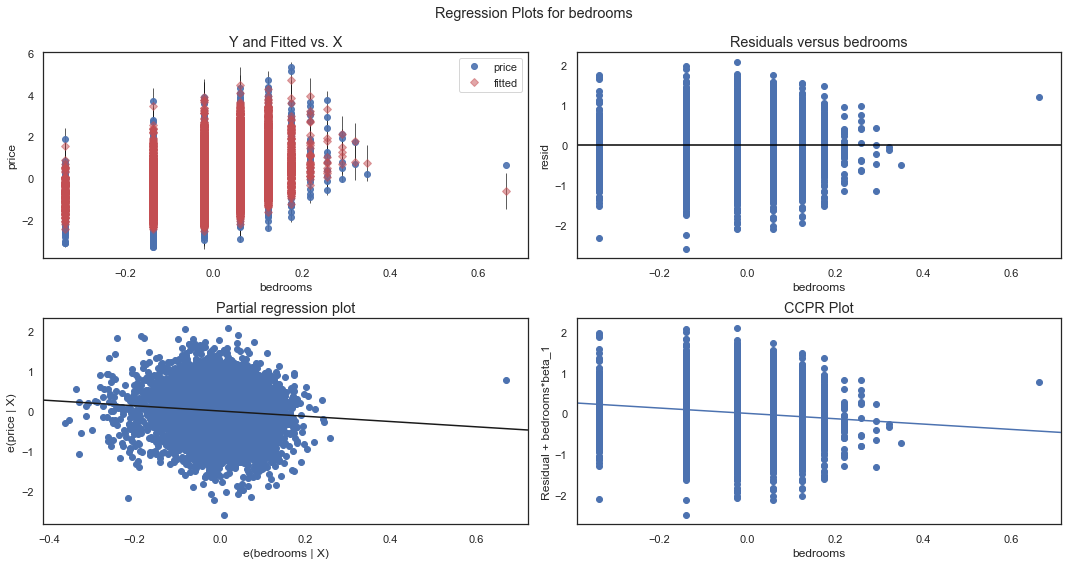

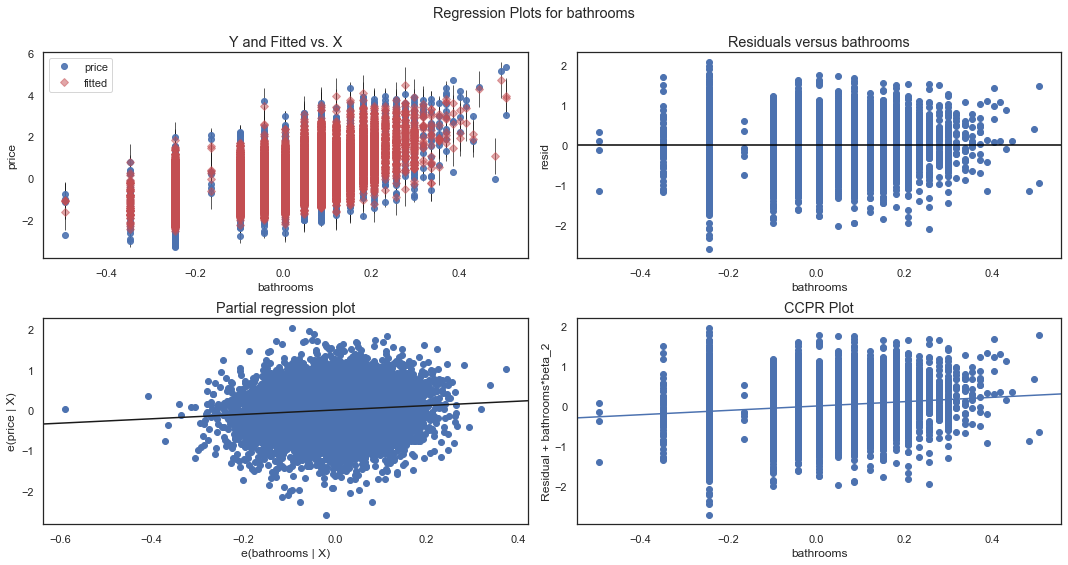

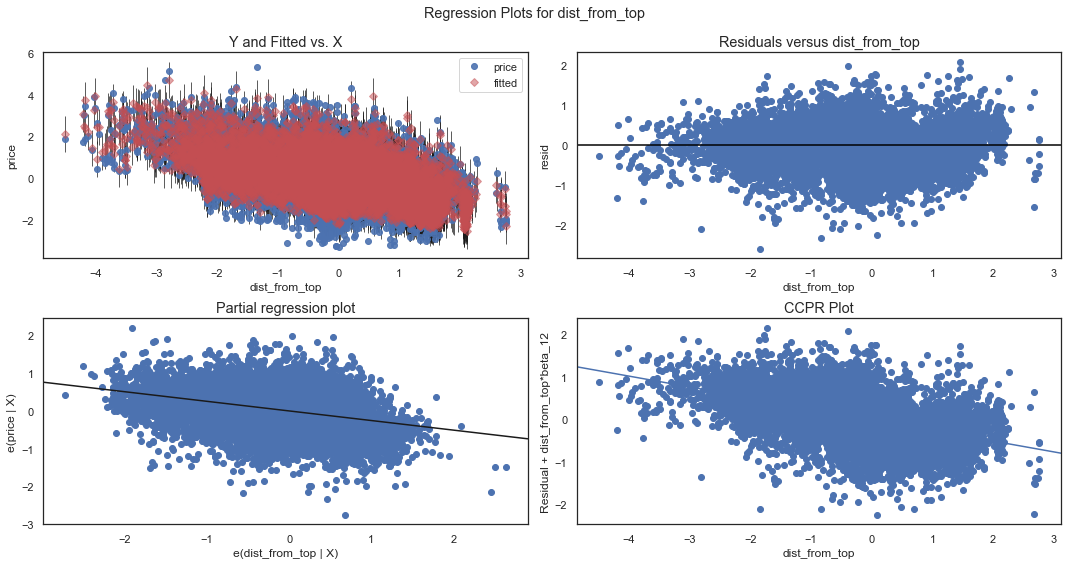

In [71]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_lot','sqft_lot15','sqft_living15','bedrooms','bathrooms','dist_from_top']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [72]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 897.1642842606705),
 ('Prob', 1.52493380643918e-195),
 ('Skew', -0.138741691902455),
 ('Kurtosis', 4.081332902170356)]

### Trial 1 Discussion
The R squared value is good but the Jarque-Bera value is too high and this along with the residuals plot indicates that normality is still an issue. In addition, the kurtosis and skew values are too high. Let's try to attack this by eliminating outliers.

## Trial 2: Eliminating Outliers

* Categorical predictors: view, waterfront, grade, condition (binned), yr_built (binned), renovated,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living, dist_from_top
* Notes: Eliminated outliers 


The process of eliminating outliers for the continuous variables consisted of simple eliminating any data point that had a Z score of over 3. This is done first by calculating the Z score as seen below.

In [73]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'dist_from_top', 'condition_(2, 5]',
       'view_(0, 3]', 'view_(3, 4]', 'waterfront_1.0', 'yr_built_(1899, 1928]',
       'yr_built_(1928, 1933]', 'yr_built_(1933, 1972]',
       'yr_built_(1972, 1982]', 'yr_built_(1982, 1990]',
       'yr_built_(1990, 2000]', 'yr_built_(2000, 2007]',
       'yr_built_(2007, 2009]', 'yr_built_(2009, 2020]', 'grade_(6, 9]',
       'grade_(9, 13]', 'Renovated?_True', 'prime_zipcode_True'],
      dtype='object')

In [74]:
df2.head()

id       date     price  bedrooms  bathrooms  sqft_lot  floors  \
0  7129300520 2014-10-13  221900.0         3       1.00      5650     1.0   
1  6414100192 2014-12-09  538000.0         3       2.25      7242     2.0   
2  5631500400 2015-02-25  180000.0         2       1.00     10000     1.0   
3  2487200875 2014-12-09  604000.0         4       3.00      5000     1.0   
4  1954400510 2015-02-18  510000.0         3       2.00      8080     1.0   

   sqft_above  sqft_basement  zipcode  ...  yr_built_(1972, 1982]  \
0        1180              0    98178  ...                      0   
1        2170            400    98125  ...                      0   
2         770              0    98028  ...                      0   
3        1050            910    98136  ...                      0   
4        1680              0    98074  ...                      0   

   yr_built_(1982, 1990]  yr_built_(1990, 2000]  yr_built_(2000, 2007]  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      1                      0                      0   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  grade_(6, 9]  grade_(9, 13]  \
0                      0                      0             1              0   
1                      0                      0             1              0   
2                      0                      0             0              0   
3                      0                      0             1              0   
4                      0                      0             1              0   

   Renovated?_True  prime_zipcode_True  
0                0                   0  
1                1                   0  
2                0                   0  
3                0                   0  
4                0                   0  

[5 rows x 32 columns]

In [75]:
df2['zsqft_above']=(df2.sqft_above-df2.sqft_above.mean())/df2.sqft_above.std()
df2['zsqft_living15']=(df2.sqft_living15-df2.sqft_living15.mean())/df2.sqft_living15.std()
df2['zsqft_lot']=(df2.sqft_lot-df2.sqft_lot.mean())/df2.sqft_lot.std()
df2['zsqft_lot15']=(df2.sqft_lot15-df2.sqft_lot15.mean())/df2.sqft_lot15.std()
df2['zprice']=(df2.price-df2.price.mean())/df2.price.std()
df2['zbathrooms']=(df2.bathrooms-df2.bathrooms.mean())/df2.bathrooms.std()
df2['zbedrooms']=(df2.bedrooms-df2.bedrooms.mean())/df2.bedrooms.std()
df2['zdist_from_top']=(df2.dist_from_top-df2.dist_from_top.mean())/df2.dist_from_top.std()



In [76]:
df2.head()

id       date     price  bedrooms  bathrooms  sqft_lot  floors  \
0  7129300520 2014-10-13  221900.0         3       1.00      5650     1.0   
1  6414100192 2014-12-09  538000.0         3       2.25      7242     2.0   
2  5631500400 2015-02-25  180000.0         2       1.00     10000     1.0   
3  2487200875 2014-12-09  604000.0         4       3.00      5000     1.0   
4  1954400510 2015-02-18  510000.0         3       2.00      8080     1.0   

   sqft_above  sqft_basement  zipcode  ...  Renovated?_True  \
0        1180              0    98178  ...                0   
1        2170            400    98125  ...                1   
2         770              0    98028  ...                0   
3        1050            910    98136  ...                0   
4        1680              0    98074  ...                0   

   prime_zipcode_True  zsqft_above  zsqft_living15  zsqft_lot  zsqft_lot15  \
0                   0    -0.735234       -0.943654  -0.228177    -0.260621   
1                   0     0.460766       -0.432877  -0.189735    -0.187695   
2                   0    -1.230546        1.070267  -0.123137    -0.172186   
3                   0    -0.892284       -0.914467  -0.243873    -0.284453   
4                   0    -0.131194       -0.272347  -0.169499    -0.192682   

     zprice  zbathrooms  zbedrooms  zdist_from_top  
0 -0.866696   -1.451039  -0.402894       -0.727626  
1 -0.006251    0.174482  -0.402894       -0.291186  
2 -0.980751   -1.451039  -1.482459       -0.224253  
3  0.173405    1.149794   0.676671       -0.254932  
4 -0.082469   -0.150622  -0.402894       -0.253023  

[5 rows x 40 columns]

From there we eliminate any row that has a Z score of over 3 for the continous variables

In [77]:
testing2=df.copy()
print(testing2.shape)
testing2=testing2.loc[df2["zprice"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zsqft_above"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zsqft_living15"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zsqft_lot"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zsqft_lot15"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zbathrooms"]<3]
print(testing2.shape)
testing2=testing2.loc[df2["zbedrooms"]<3]
print(testing2.shape)



(21597, 30)
(21191, 30)
(21048, 30)
(20942, 30)
(20631, 30)
(20505, 30)
(20438, 30)
(20397, 30)


We now have the same DataFrame as trial 2 except without the outilers. Let's confirm this. 

In [78]:
testing2.shape

(20397, 30)

In [79]:
x=testing2.drop(['price'],axis=1)
y=testing2.price

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [81]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
2237   0.059624   0.005599  0.021097 -0.197639   -0.271173      -0.798211   
20362  0.123443   0.207438 -0.142241  0.202361    1.921945      -0.798211   
8701  -0.138616  -0.244401 -0.891779 -0.197639   -1.236630       0.657181   
14031  0.059624   0.086081  0.146849  0.202361    1.113877      -0.798211   
9028  -0.336856  -0.244401 -0.672448 -0.197639   -1.605663       0.979861   

       zipcode      lat     long  sqft_living15  ...  yr_built_(1972, 1982]  \
2237     98031  47.3933 -122.195      -0.551698  ...                      0   
20362    98074  47.5929 -122.057       1.594031  ...                      0   
8701     98107  47.6721 -122.395      -0.551698  ...                      0   
14031    98033  47.6916 -122.203       0.533602  ...                      0   
9028     98166  47.4653 -122.338      -1.638114  ...                      0   

       yr_built_(1982, 1990]  yr_built_(1990, 2000]  yr_built_(2000, 2007]  \
2237                       0                      0                      0   
20362                      0                      0                      0   
8701                       0                      0                      0   
14031                      0                      1                      0   
9028                       0                      0                      0   

       yr_built_(2007, 2009]  yr_built_(2009, 2020]  grade_(6, 9]  \
2237                       0                      0             1   
20362                      0                      1             1   
8701                       0                      0             1   
14031                      0                      0             1   
9028                       0                      0             0   

       grade_(9, 13]  Renovated?_True  prime_zipcode_True  
2237               0                0                   0  
20362              0                0                   0  
8701               0                0                   0  
14031              0                0                   0  
9028               0                0                   0  

[5 rows x 29 columns]

In [82]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1955.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:06:39   Log-Likelihood:                -9505.5
No. Observations:               16317   AIC:                         1.907e+04
Df Residuals:                   16288   BIC:                         1.929e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -32.2878      6.603     -4.890      0.000     -45.230     -19.346
bedrooms                 -0.5856      0.058    -10.107      0.000      -0.699      -0.472
bathrooms                 0.4583      0.044     10.338      0.000       0.371       0.545
sqft_lot                  0.0160      0.009      1.861      0.063      -0.001       0.033
floors                    0.0407      0.028      1.476      0.140      -0.013       0.095
sqft_above                0.3757      0.008     45.930      0.000       0.360       0.392
sqft_basement             0.1557      0.005     32.294      0.000       0.146       0.165
zipcode                  -0.0006    8.3e-05     -7.642      0.000      -0.001      -0.000
lat                       2.0983      0.030     68.896      0.000       2.039       2.158
long                      0.0196      0.034      0.569      0.569      -0.048       0.087
sqft_living15             0.1378      0.006     23.757      0.000       0.126       0.149
sqft_lot15                0.0877      0.016      5.611      0.000       0.057       0.118
dist_from_top            -0.2492      0.005    -47.947      0.000      -0.259      -0.239
condition_(2, 5]          0.4115      0.035     11.597      0.000       0.342       0.481
view_(0, 3]               0.3220      0.014     23.353      0.000       0.295       0.349
view_(3, 4]               0.6615      0.041     16.262      0.000       0.582       0.741
waterfront_1.0            0.7238      0.066     10.966      0.000       0.594       0.853
yr_built_(1899, 1928]    -3.3335      0.735     -4.533      0.000      -4.775      -1.892
yr_built_(1928, 1933]    -3.4381      0.736     -4.671      0.000      -4.881      -1.995
yr_built_(1933, 1972]    -3.6503      0.735     -4.966      0.000      -5.091      -2.209
yr_built_(1972, 1982]    -3.7395      0.733     -5.104      0.000      -5.176      -2.303
yr_built_(1982, 1990]    -3.6861      0.733     -5.030      0.000      -5.122      -2.250
yr_built_(1990, 2000]    -3.6587      0.733     -4.991      0.000      -5.095      -2.222
yr_built_(2000, 2007]    -3.6525      0.733     -4.984      0.000      -5.089      -2.216
yr_built_(2007, 2009]    -3.6349      0.733     -4.959      0.000      -5.072      -2.198
yr_built_(2009, 2020]    -3.4942      0.733     -4.766      0.000      -4.931      -2.057
grade_(6, 9]              0.2327      0.013     17.892      0.000       0.207       0.258
grade_(9, 13]             0.5566      0.023     24.466      0.000       0.512       0.601
Renovated?_True           0.1123      0.020      5.577      0.000       0.073       0.152
prime_zipcode_True        0.3996      0.022     18.330      0.000       0.357       0.442
==============================================================================
Omnibus:                      474.

In [83]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [84]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.18772639178021297
Test Mean Squarred Error: 0.18805804204232884


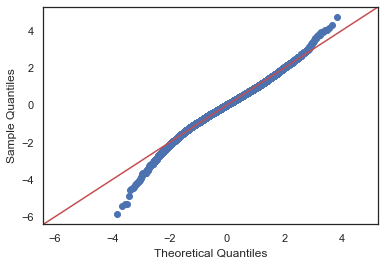

In [85]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

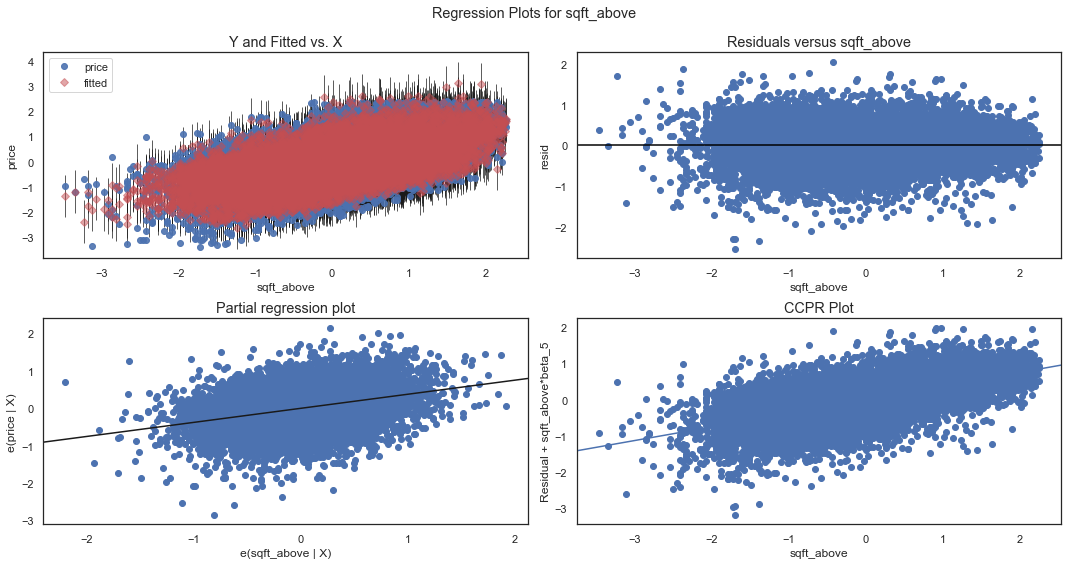

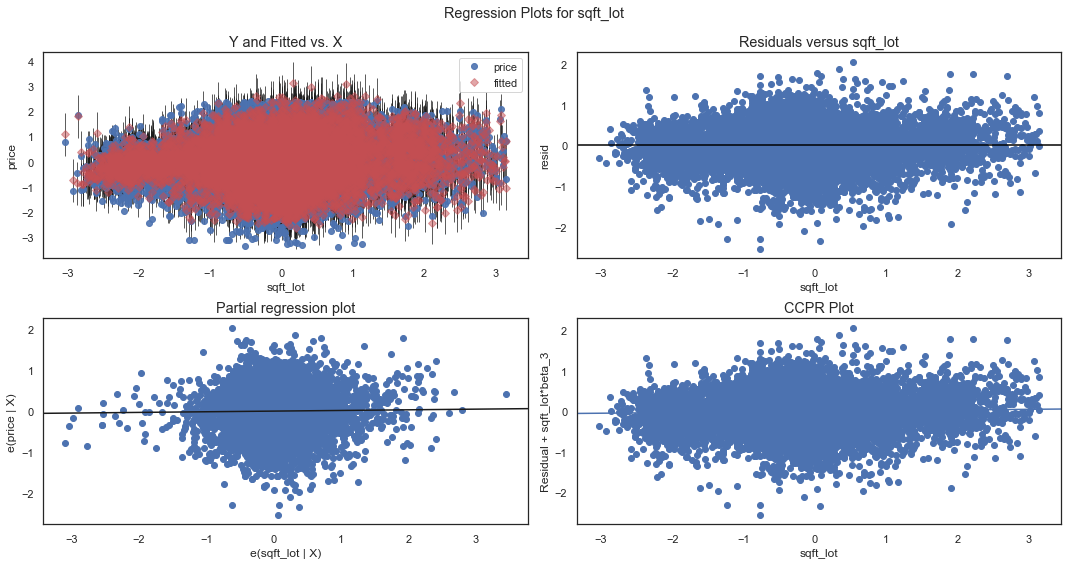

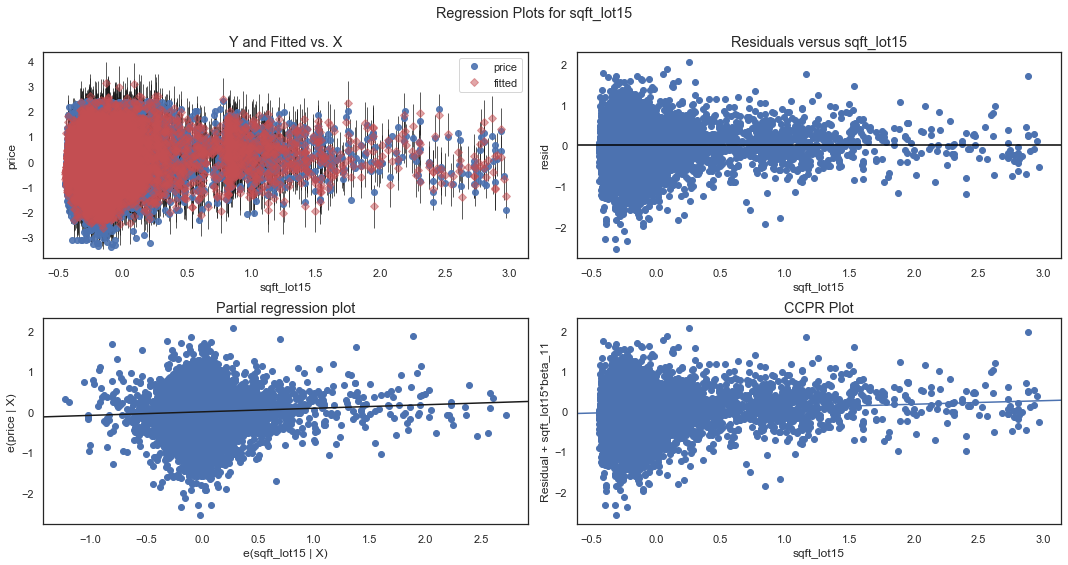

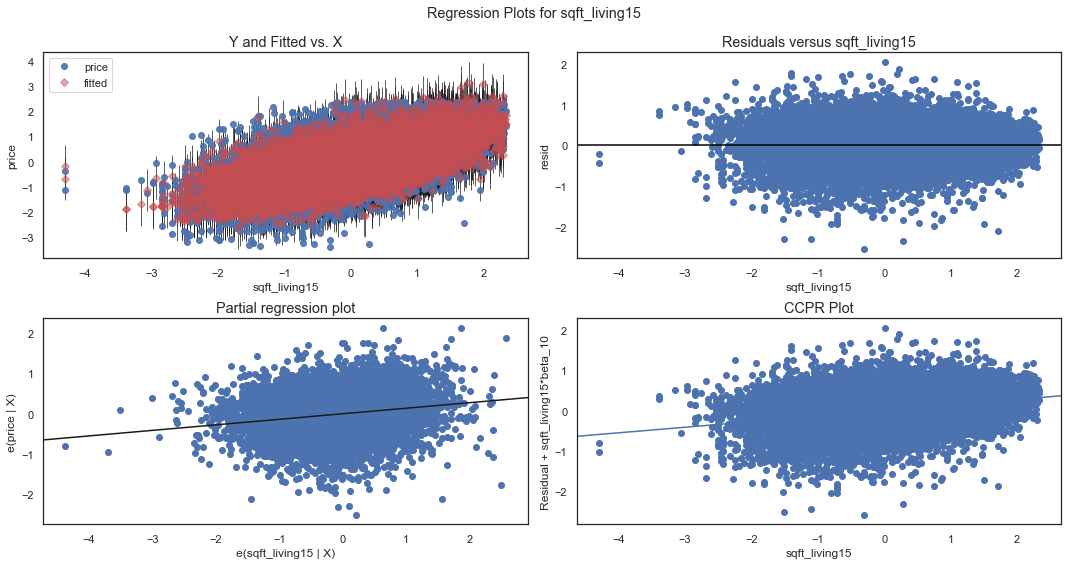

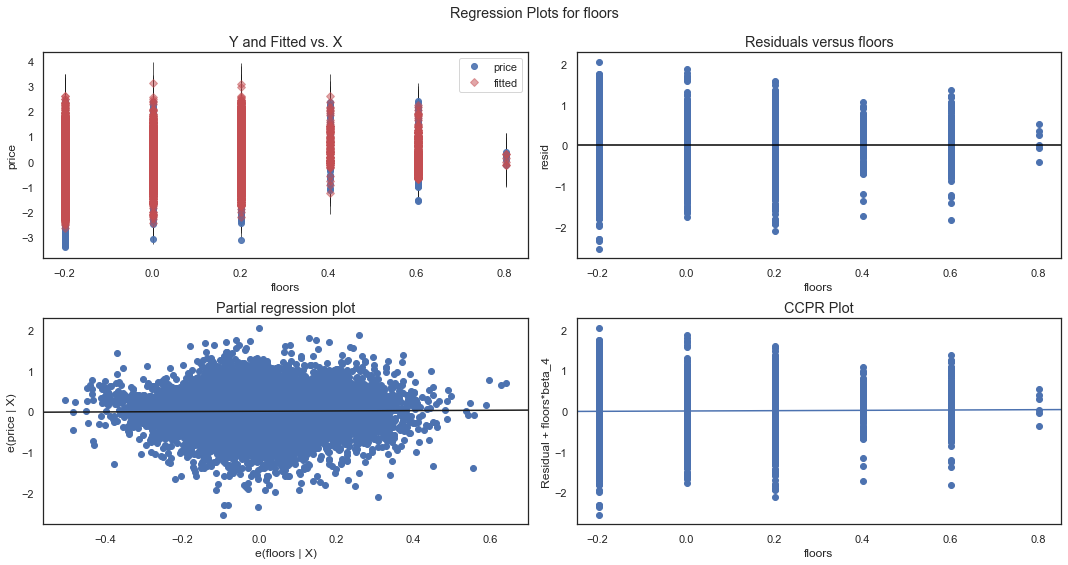

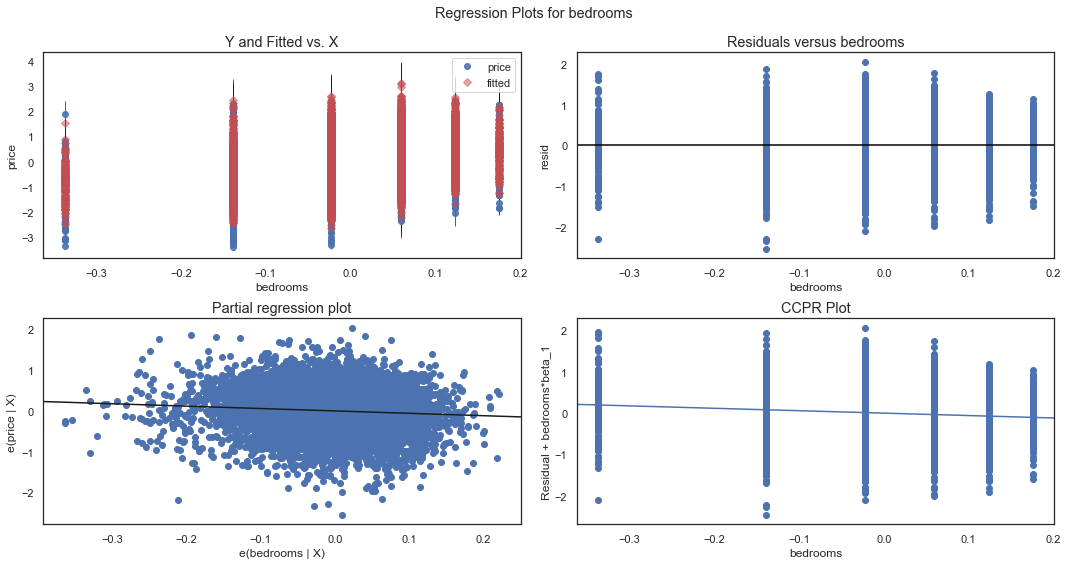

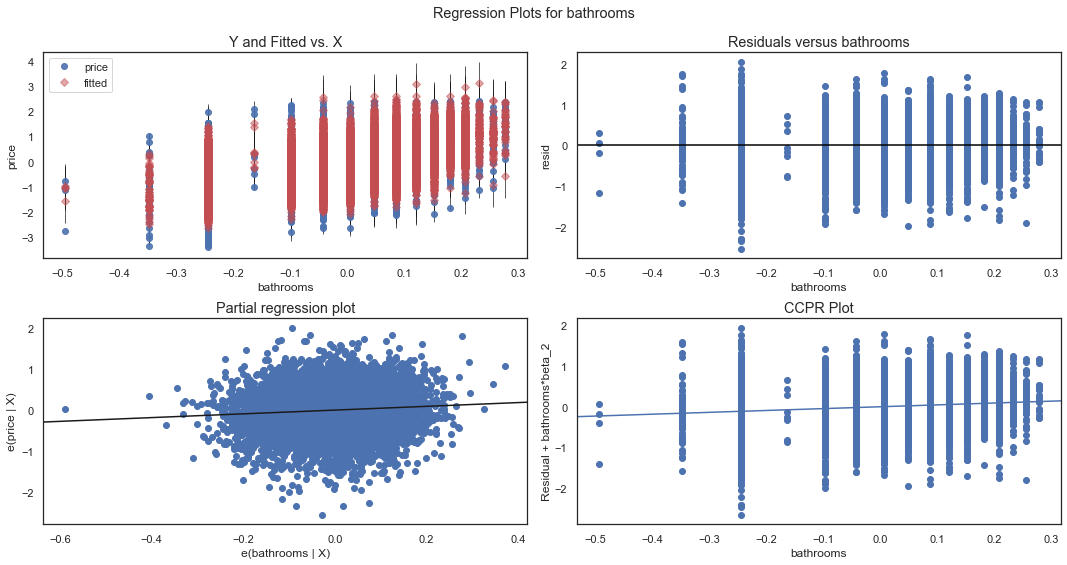

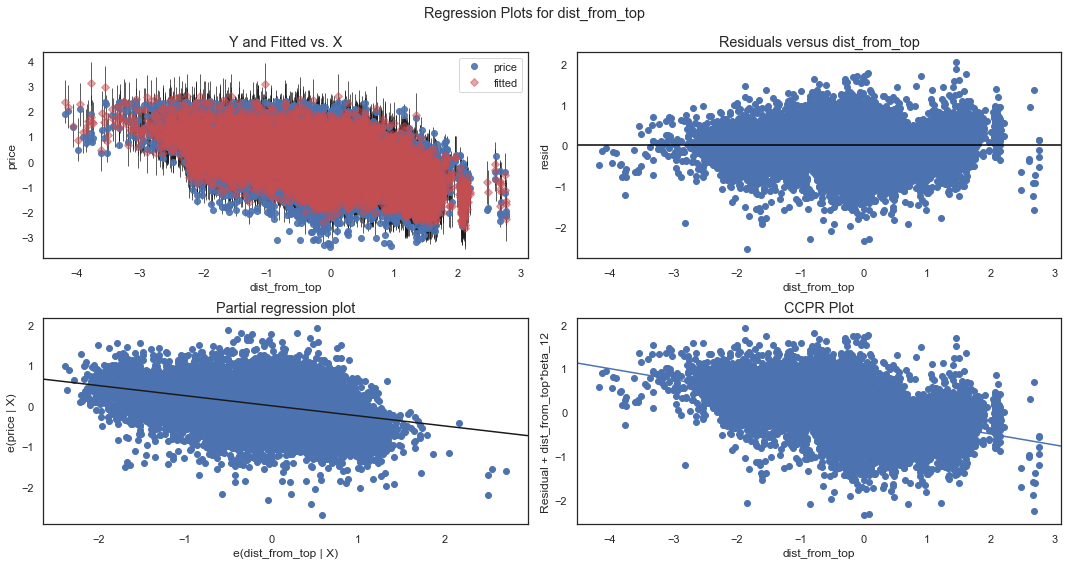

In [86]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms','dist_from_top']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [87]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 953.0227122248994),
 ('Prob', 1.1317421117117269e-207),
 ('Skew', -0.19981925106237639),
 ('Kurtosis', 4.1144732984518875)]

### Trial 2 Discussion:
Overall eliminating the outliers produced worse results. Thus we will keep the outliers in the model. The next step is to see if we can reduce the number of predictors in the model. The first method of choice is eliminating or changing the methodology behind the predictor yr_built. 

## Trial 3: Introduction of Age variable

* Categorical predictors: view (binned), waterfront, grade, condition (binned), renovated? ,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_living15, sqft_living, age, dist_from_top
* Notes: Added a new variable named age and dropped yr_built

The variable age is introduced where it will be the age of the house and we drop the categorical variables for yr_built.

In [88]:
df['age']=2020-df3.yr_built
df.drop(new_age,axis=1,inplace=True)
df.head()

price  bedrooms  bathrooms  sqft_lot    floors  sqft_above  \
0 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   -0.753565   
1  0.279938 -0.022653   0.048081 -0.113241  0.202361    0.672693   
2 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   -1.752954   
3  0.499698  0.059624   0.151840 -0.523914 -0.197639   -1.026835   
4  0.178434 -0.022653   0.005599  0.008139 -0.197639    0.073515   

   sqft_basement  zipcode      lat     long  ...  dist_from_top  \
0      -0.798211    98178  47.5112 -122.257  ...      -0.620617   
1       1.092003    98125  47.7210 -122.319  ...      -0.039721   
2      -0.798211    98028  47.7379 -122.233  ...       0.034583   
3       1.350776    98136  47.5208 -122.393  ...       0.000914   
4      -0.798211    98074  47.6168 -122.045  ...       0.003028   

   condition_(2, 5]  view_(0, 3]  view_(3, 4]  waterfront_1.0  grade_(6, 9]  \
0                 1            0            0               0             1   
1                 1            0            0               0             1   
2                 1            0            0               0             0   
3                 1            0            0               0             1   
4                 1            0            0               0             1   

   grade_(9, 13]  Renovated?_True  prime_zipcode_True  age  
0              0                0                   0   65  
1              0                1                   0   69  
2              0                0                   0   87  
3              0                0                   0   55  
4              0                0                   0   33  

[5 rows x 22 columns]

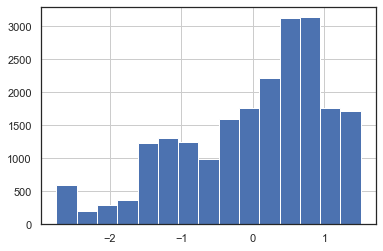

In [89]:
df.age=np.log(df.age)
df.age=(df.age-df.age.mean())/df.age.std()
df.age.hist(bins=15)

In [90]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'dist_from_top', 'condition_(2, 5]', 'view_(0, 3]',
       'view_(3, 4]', 'waterfront_1.0', 'grade_(6, 9]', 'grade_(9, 13]',
       'Renovated?_True', 'prime_zipcode_True', 'age'],
      dtype='object')

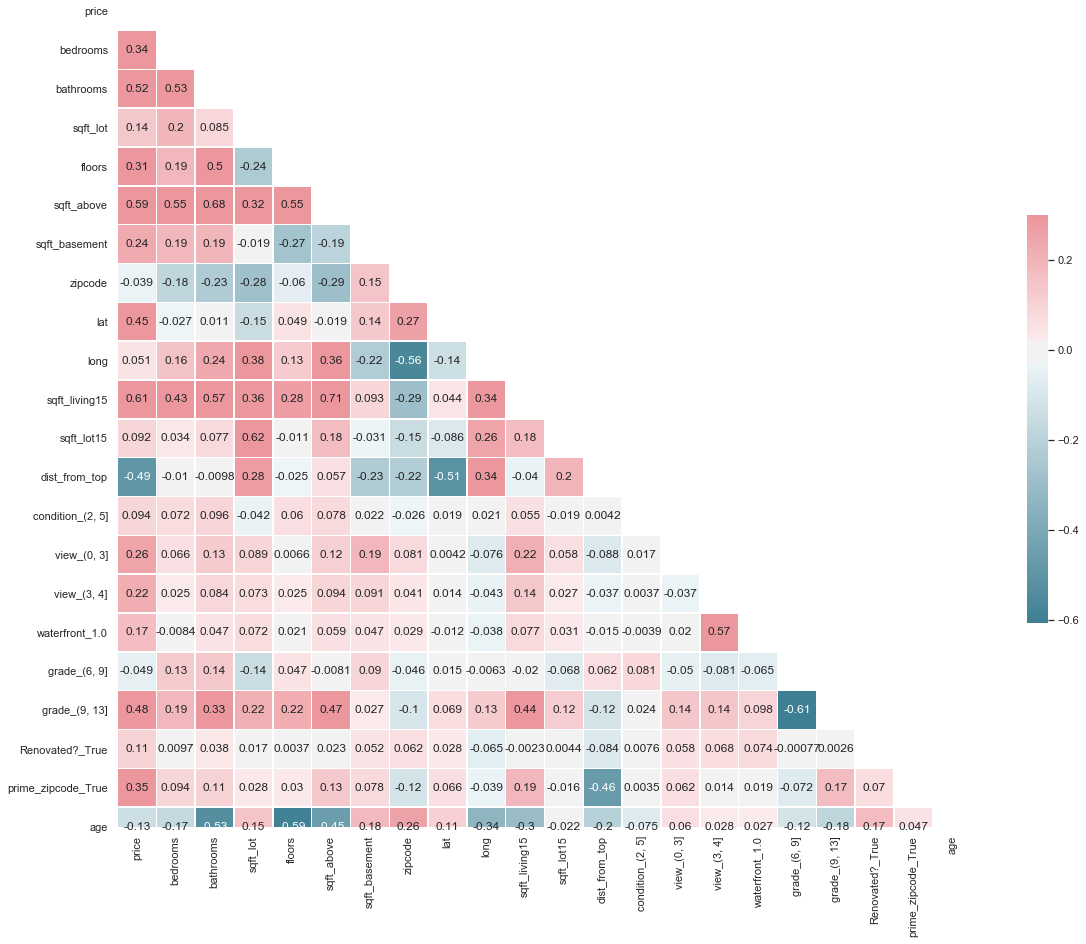

In [91]:
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [92]:
(abs(df.corr())>.75).sum()-1

price                 0
bedrooms              0
bathrooms             0
sqft_lot              0
floors                0
sqft_above            0
sqft_basement         0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
dist_from_top         0
condition_(2, 5]      0
view_(0, 3]           0
view_(3, 4]           0
waterfront_1.0        0
grade_(6, 9]          0
grade_(9, 13]         0
Renovated?_True       0
prime_zipcode_True    0
age                   0
dtype: int64

In [93]:
x=df.drop(['price'],axis=1)
y=df.price

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [95]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
3902   0.059624   0.180709  1.724860  0.202361    1.661176       0.990889   
17608 -0.022653  -0.098160 -0.459320 -0.197639   -0.875740       1.416190   
1009   0.059624  -0.042562 -0.418258  0.002361   -1.026835       1.268142   
14026  0.059624  -0.042562 -0.299849 -0.197639   -0.455876       1.472700   
17575  0.059624  -0.244401 -0.368403  0.002361    0.410393      -0.798211   

       zipcode      lat     long  sqft_living15  ...  dist_from_top  \
3902     98034  47.7124 -122.253       0.794765  ...      -0.331297   
17608    98117  47.6927 -122.395      -0.237744  ...       0.069697   
1009     98117  47.6802 -122.388      -0.418492  ...      -0.084950   
14026    98117  47.6965 -122.393       0.640762  ...       0.088802   
17575    98177  47.7188 -122.358       0.436650  ...       0.104659   

       condition_(2, 5]  view_(0, 3]  view_(3, 4]  waterfront_1.0  \
3902                  1            1            0               0   
17608                 1            0            0               0   
1009                  1            0            0               0   
14026                 1            0            0               0   
17575                 1            0            0               0   

       grade_(6, 9]  grade_(9, 13]  Renovated?_True  prime_zipcode_True  \
3902              0              1                0                   0   
17608             1              0                0                   0   
1009              1              0                0                   0   
14026             1              0                0                   0   
17575             1              0                0                   0   

            age  
3902  -0.391899  
17608  0.687861  
1009   1.181401  
14026  0.602890  
17575  0.843147  

[5 rows x 21 columns]

In [96]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     3214.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:06:51   Log-Likelihood:                -10792.
No. Observations:               17277   AIC:                         2.163e+04
Df Residuals:                   17255   BIC:                         2.180e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -58.4776      7.416     -7.885      0.000     -73.014     -43.941
bedrooms              -0.7144      0.057    -12.499      0.000      -0.826      -0.602
bathrooms              0.4385      0.044     10.053      0.000       0.353       0.524
sqft_lot               0.0095      0.006      1.547      0.122      -0.003       0.022
floors                 0.1683      0.025      6.614      0.000       0.118       0.218
sqft_above             0.4121      0.008     51.531      0.000       0.396       0.428
sqft_basement          0.1628      0.005     34.129      0.000       0.153       0.172
zipcode               -0.0004    8.4e-05     -4.737      0.000      -0.001      -0.000
lat                    1.9896      0.031     64.561      0.000       1.929       2.050
long                  -0.0182      0.034     -0.531      0.595      -0.085       0.049
sqft_living15          0.1316      0.006     23.305      0.000       0.121       0.143
sqft_lot15             0.0483      0.005     10.230      0.000       0.039       0.058
dist_from_top         -0.2655      0.005    -51.065      0.000      -0.276      -0.255
condition_(2, 5]       0.3824      0.036     10.588      0.000       0.312       0.453
view_(0, 3]            0.3353      0.013     25.074      0.000       0.309       0.362
view_(3, 4]            0.6918      0.035     19.693      0.000       0.623       0.761
waterfront_1.0         0.6807      0.051     13.354      0.000       0.581       0.781
grade_(6, 9]           0.1894      0.013     14.414      0.000       0.164       0.215
grade_(9, 13]          0.5816      0.022     26.894      0.000       0.539       0.624
Renovated?_True        0.1537      0.019      7.908      0.000       0.116       0.192
prime_zipcode_True     0.4112      0.021     19.832      0.000       0.371       0.452
age                    0.0470      0.005      8.808      0.000       0.037       0.057
==============================================================================
Omnibus:                      284.170   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.851
Skew:                          -0.078   Prob(JB):                    9.77e-118
Kurtosis:                       3.851   Cond. No.                     2.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [98]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.2042204220069915
Test Mean Squarred Error: 0.211551436426205


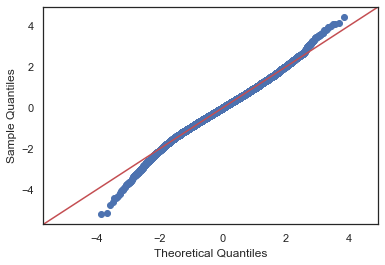

In [99]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

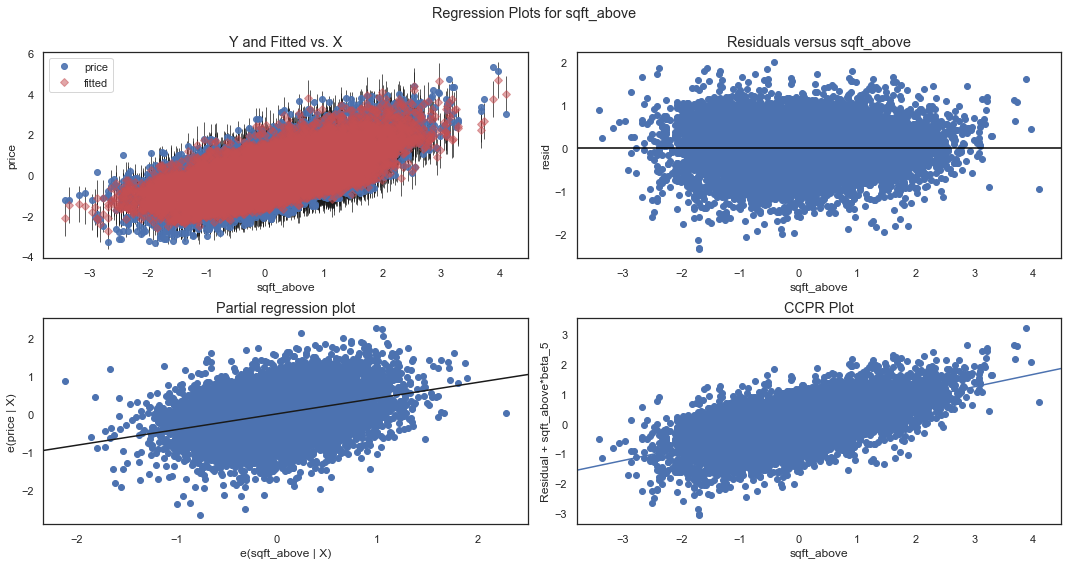

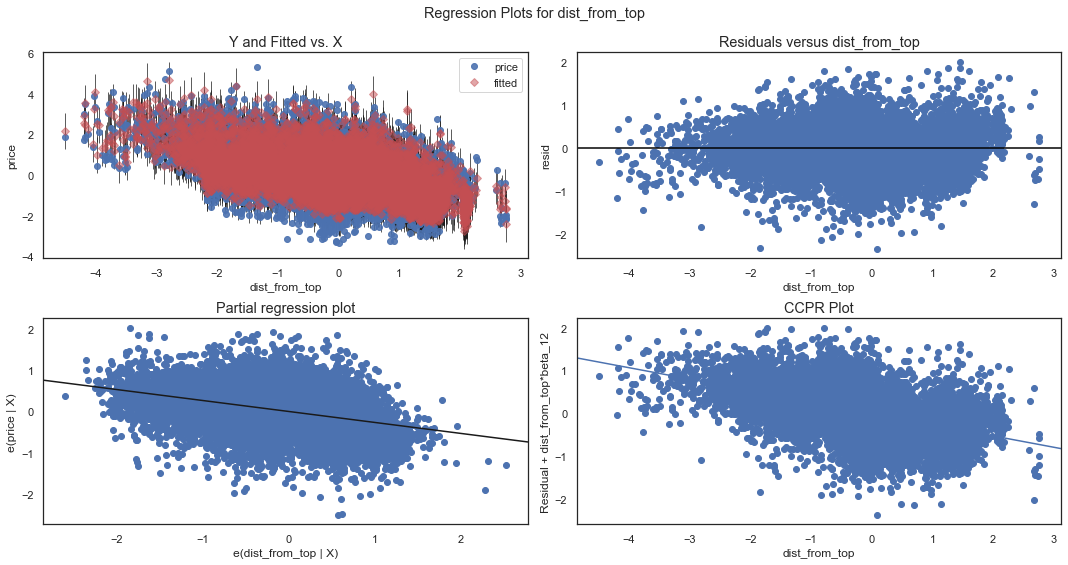

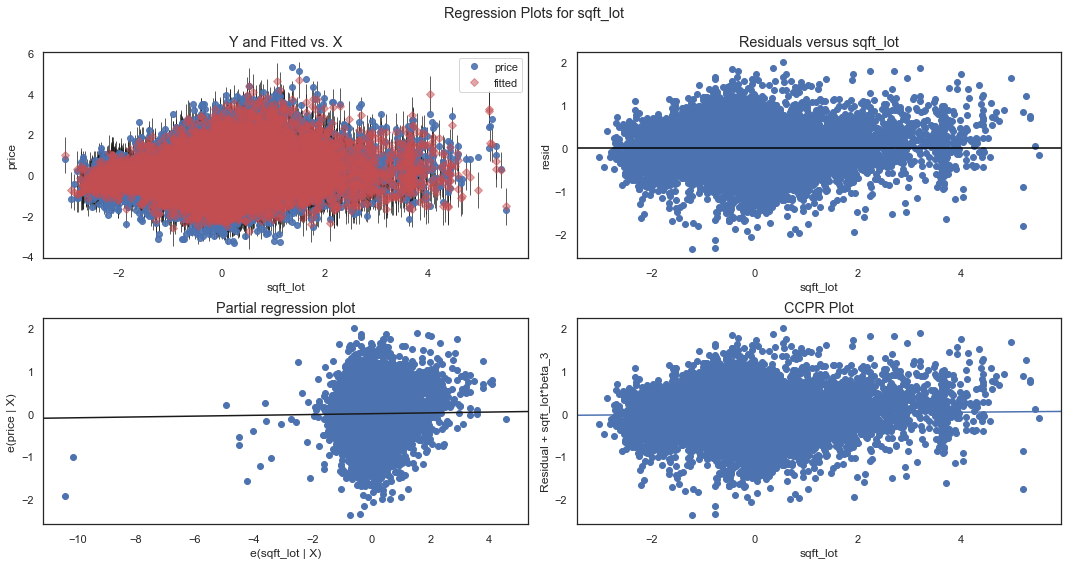

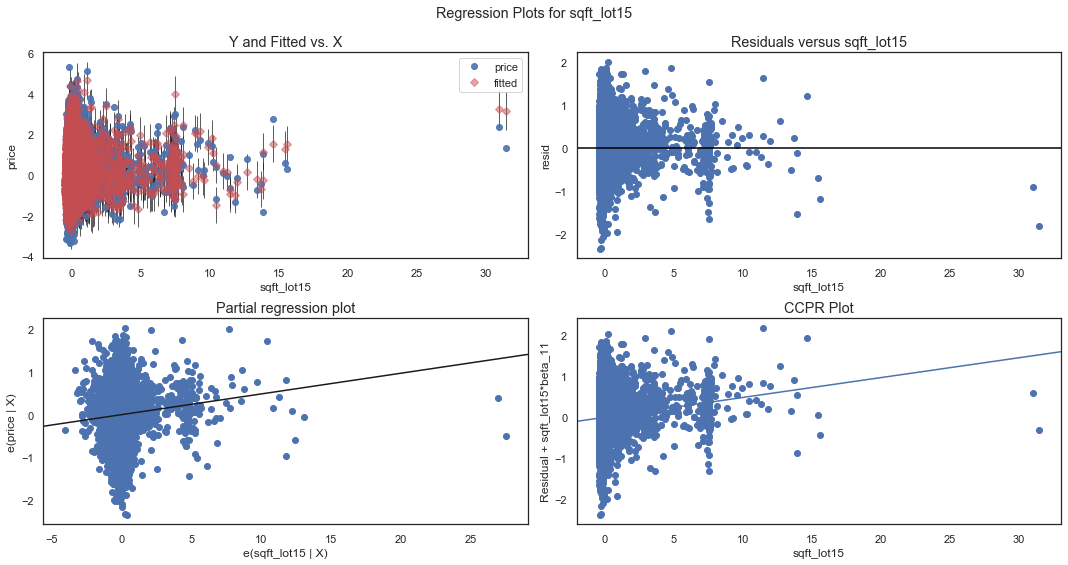

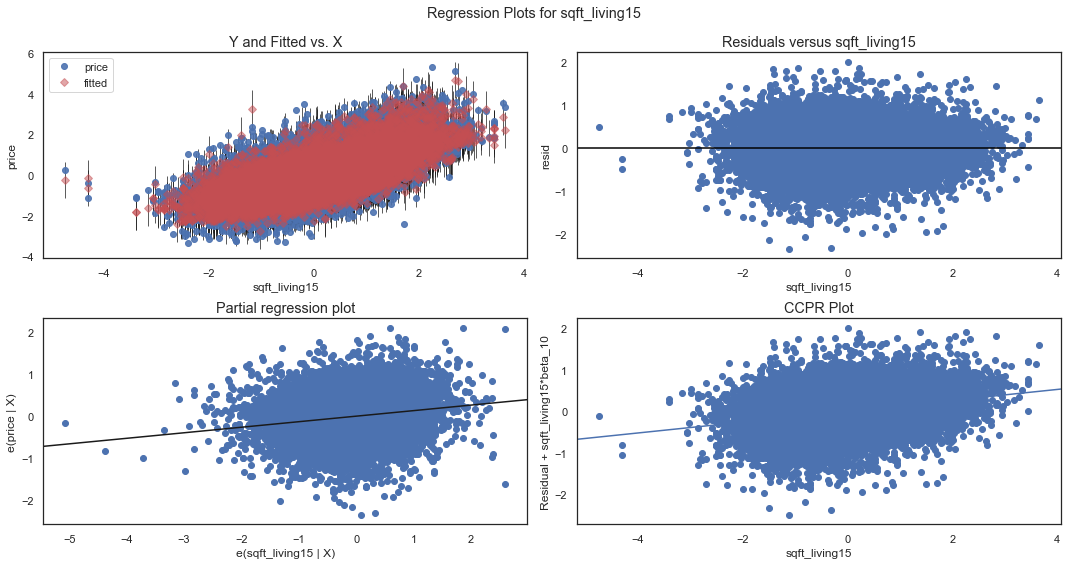

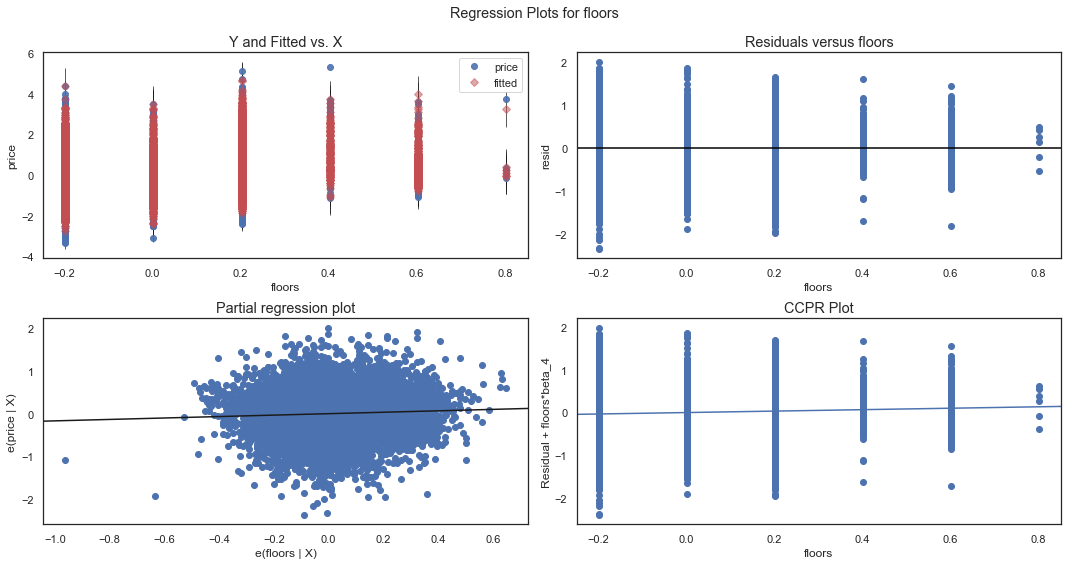

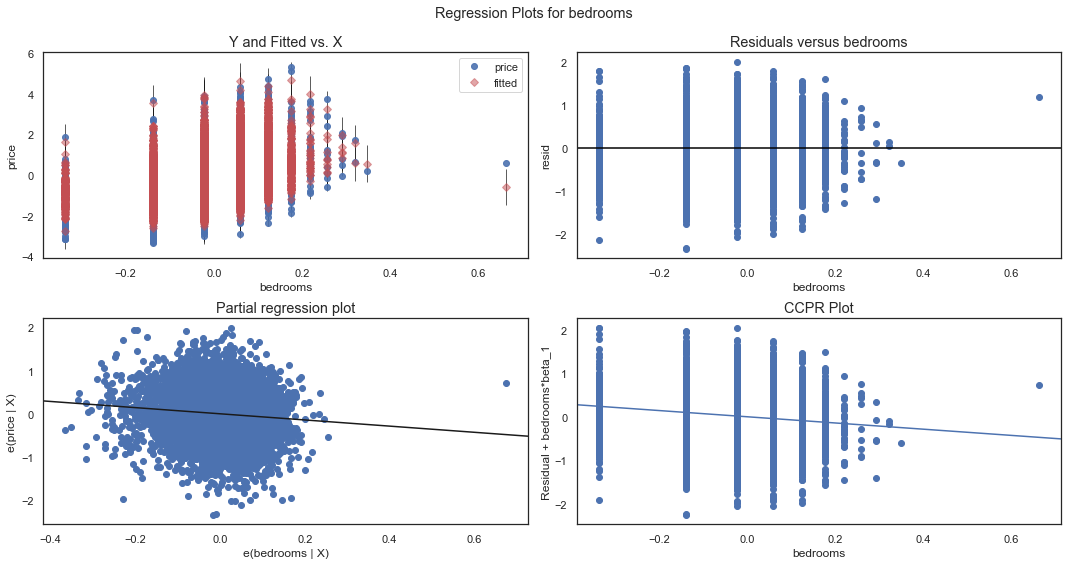

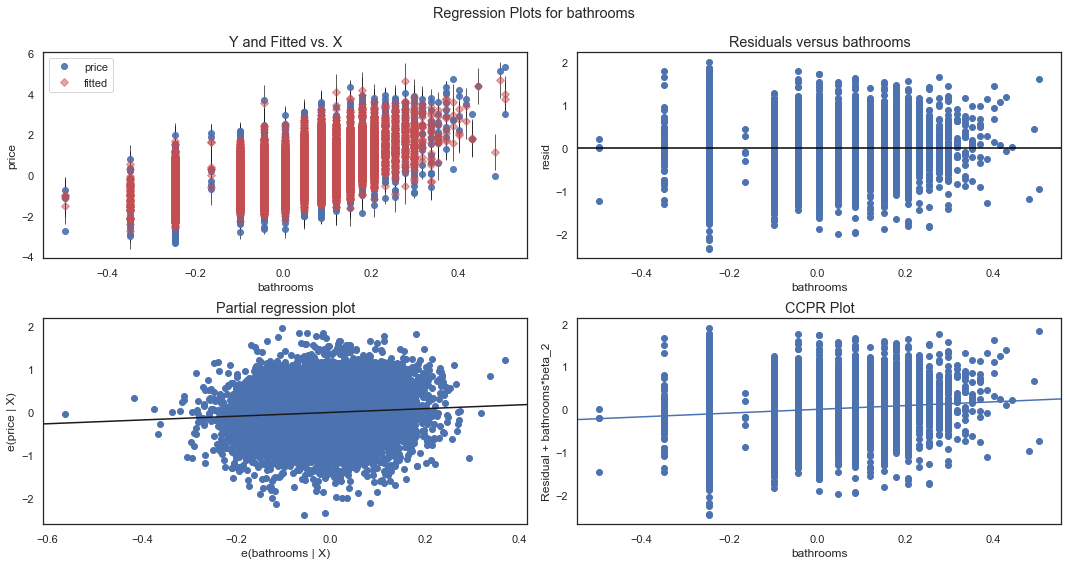

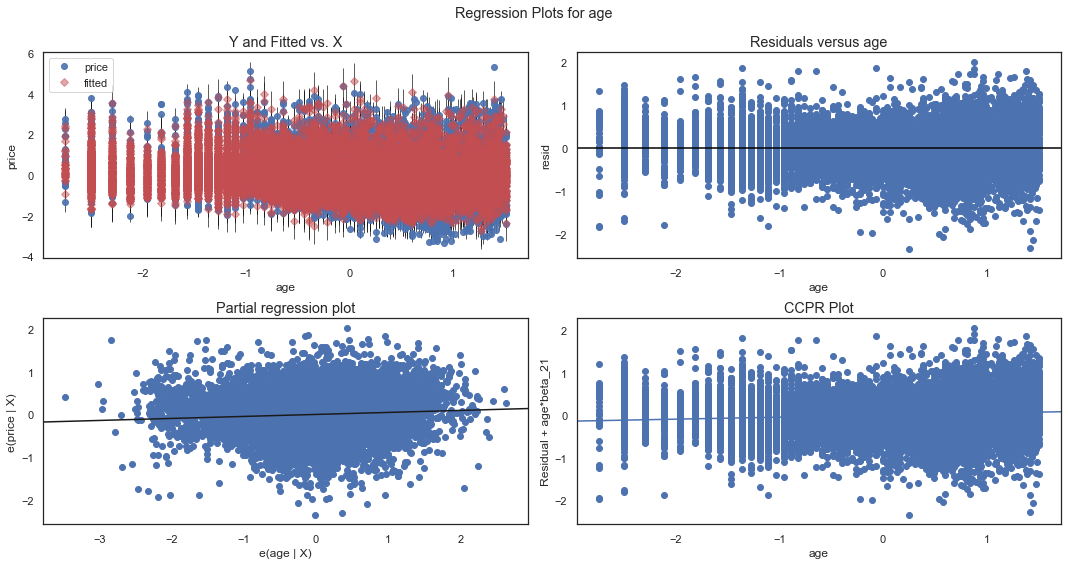

In [100]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','dist_from_top','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms','age']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [101]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 538.8507194210126),
 ('Prob', 9.773564714272842e-118),
 ('Skew', -0.07842457381480067),
 ('Kurtosis', 3.8508419804136342)]

### Trial 3 Discussion:
Although the R squared value decreased, and the residual plots seem to improve when it comes to normality. This is also evident by the decrease in the Jarque-Bera value. In addition the skew and kurtosis have decreased. Thus elimination of the categorical variables and the new age variable to represent improves the model. However, it seems as though some variables need to be dropped as they have a high p value. Therefore, longitude, sqft_lot, and floors will be dropped the model will then be evaluated. We'll also drop the predictor zipcode as from the joint plots it showed minimal linearity with respect to price and the introduction of the variables prime_zipcode and dist_from_top can represent the relationship between zipcode and price better. 

## Trial 4:  Drop floors, long, zipcode , and sqft_lot

* Categorical predictors: view (binned) , waterfront, grade, condition (binned), renovated?
* Quantitative predictors: bedrooms, bathrooms, sqft_above, lat, sqft_living15, sqft_living, age
* Notes: Dropped floors, long, and sqft_lot


In [102]:
x=df.drop(['floors','long','sqft_lot','price','zipcode'],axis=1)
y=df.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [103]:
x.head()

bedrooms  bathrooms  sqft_above  sqft_basement      lat  sqft_living15  \
0 -0.022653  -0.244401   -0.753565      -0.798211  47.5112      -1.035429   
1 -0.022653   0.048081    0.672693       1.092003  47.7210      -0.326781   
2 -0.138616  -0.244401   -1.752954      -0.798211  47.7379       1.126504   
3  0.059624   0.151840   -1.026835       1.350776  47.5208      -0.990187   
4 -0.022653   0.005599    0.073515      -0.798211  47.6168      -0.134218   

   sqft_lot15  dist_from_top  condition_(2, 5]  view_(0, 3]  view_(3, 4]  \
0   -0.260621      -0.620617                 1            0            0   
1   -0.187695      -0.039721                 1            0            0   
2   -0.172186       0.034583                 1            0            0   
3   -0.284453       0.000914                 1            0            0   
4   -0.192682       0.003028                 1            0            0   

   waterfront_1.0  grade_(6, 9]  grade_(9, 13]  Renovated?_True  \
0               0             1              0                0   
1               0             1              0                1   
2               0             0              0                0   
3               0             1              0                0   
4               0             1              0                0   

   prime_zipcode_True       age  
0                   0  0.687861  
1                   0  0.767756  
2                   0  1.077870  
3                   0  0.464369  
4                   0 -0.219034

In [104]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3953.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:07:07   Log-Likelihood:                -10824.
No. Observations:               17277   AIC:                         2.168e+04
Df Residuals:                   17259   BIC:                         2.182e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -94.4198      1.428    -66.142      0.000     -97.218     -91.622
bedrooms              -0.7312      0.057    -12.840      0.000      -0.843      -0.620
bathrooms              0.4978      0.043     11.613      0.000       0.414       0.582
sqft_above             0.4274      0.007     57.376      0.000       0.413       0.442
sqft_basement          0.1546      0.005     33.366      0.000       0.145       0.164
lat                    1.9719      0.030     65.654      0.000       1.913       2.031
sqft_living15          0.1317      0.005     24.432      0.000       0.121       0.142
sqft_lot15             0.0524      0.004     14.109      0.000       0.045       0.060
dist_from_top         -0.2664      0.005    -54.636      0.000      -0.276      -0.257
condition_(2, 5]       0.3788      0.036     10.487      0.000       0.308       0.450
view_(0, 3]            0.3302      0.013     24.902      0.000       0.304       0.356
view_(3, 4]            0.6861      0.035     19.544      0.000       0.617       0.755
waterfront_1.0         0.6875      0.051     13.484      0.000       0.588       0.787
grade_(6, 9]           0.1895      0.013     14.501      0.000       0.164       0.215
grade_(9, 13]          0.5806      0.022     26.881      0.000       0.538       0.623
Renovated?_True        0.1590      0.019      8.192      0.000       0.121       0.197
prime_zipcode_True     0.4226      0.020     20.663      0.000       0.382       0.463
age                    0.0349      0.005      7.542      0.000       0.026       0.044
==============================================================================
Omnibus:                      295.679   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.584
Skew:                          -0.090   Prob(JB):                    1.87e-122
Kurtosis:                       3.864   Cond. No.                     1.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.20497046113142614
Test Mean Squarred Error: 0.21218532123601844


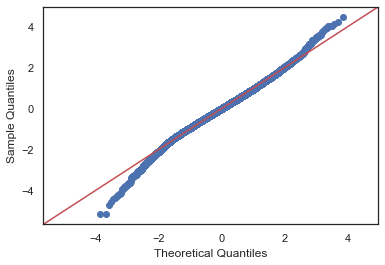

In [106]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

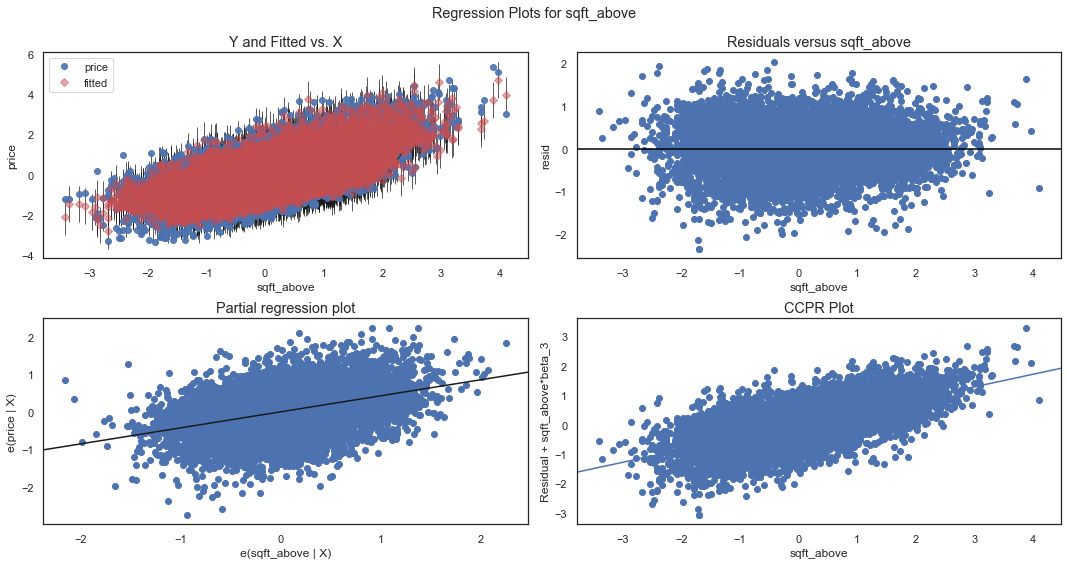

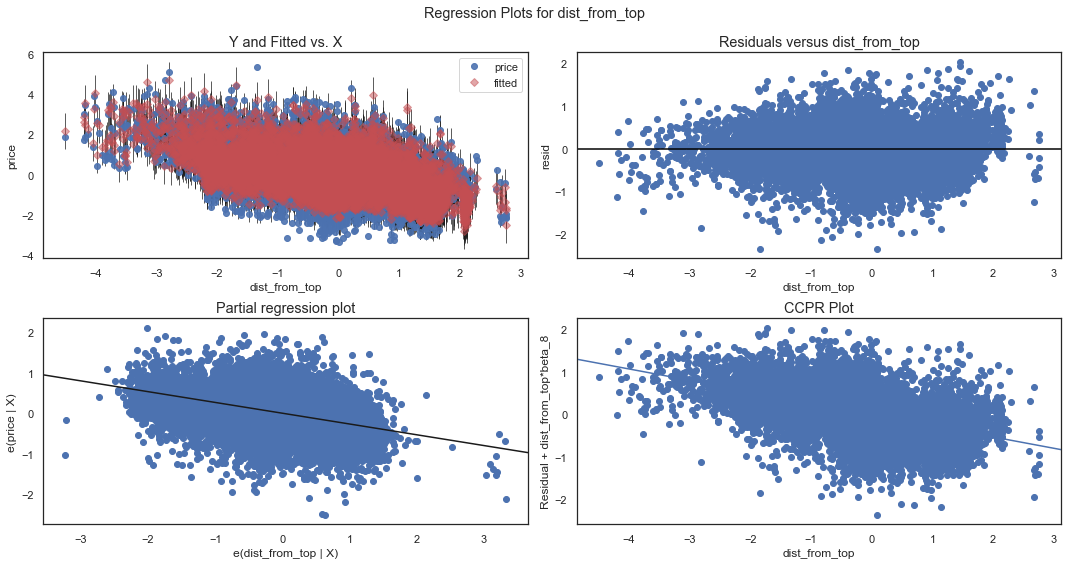

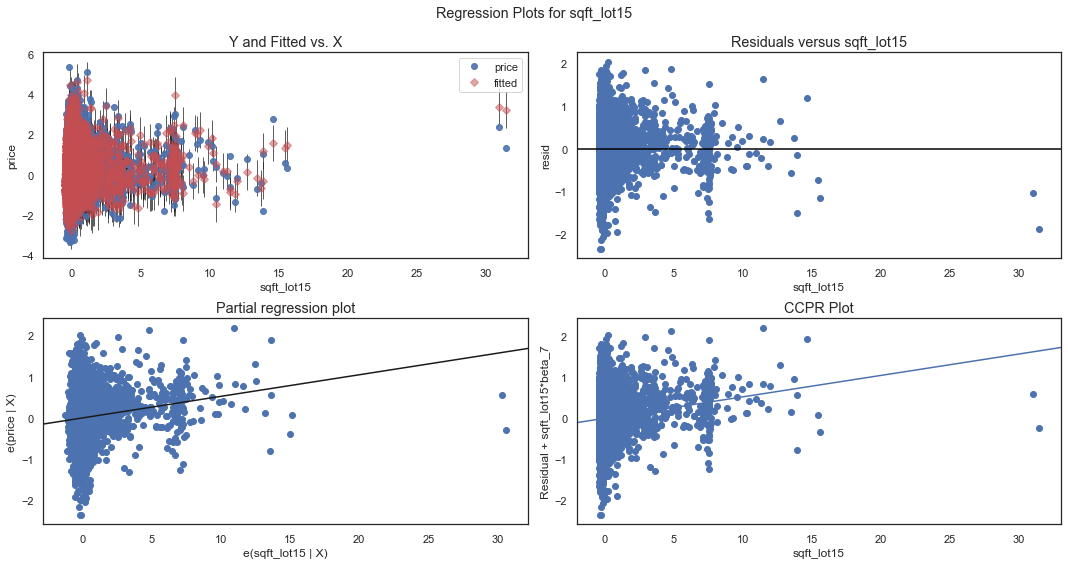

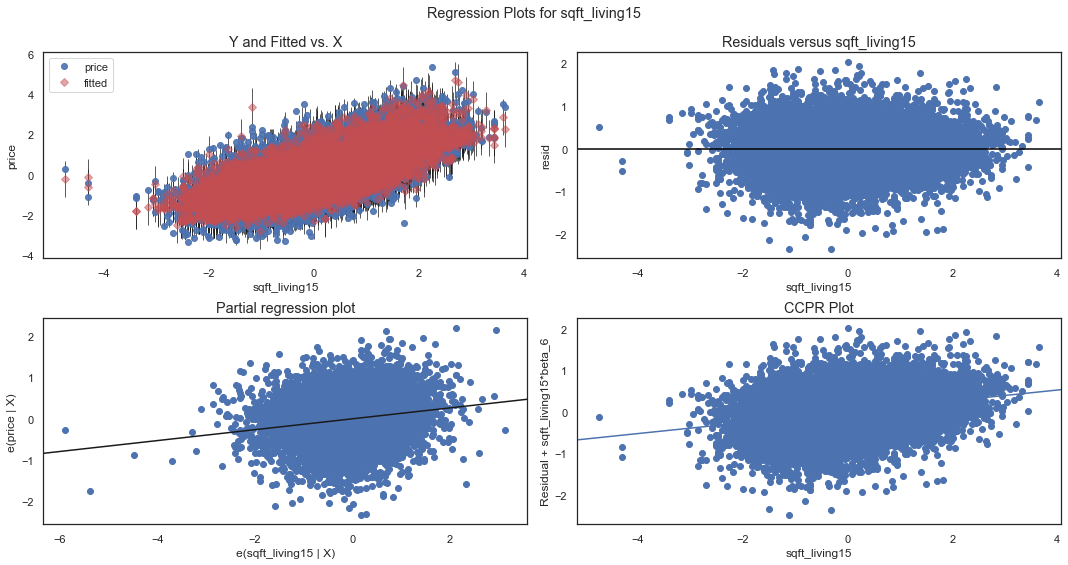

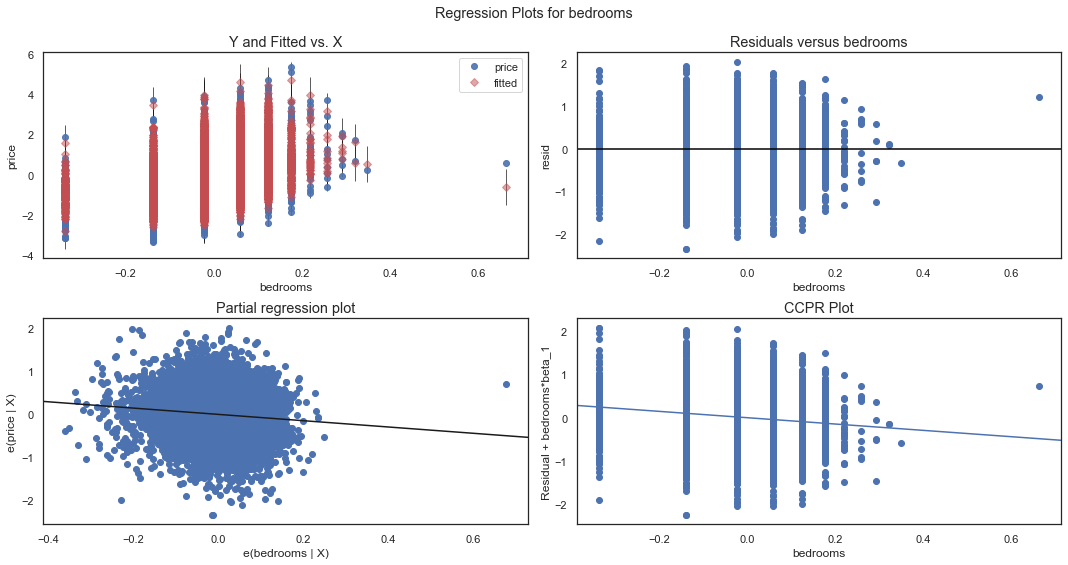

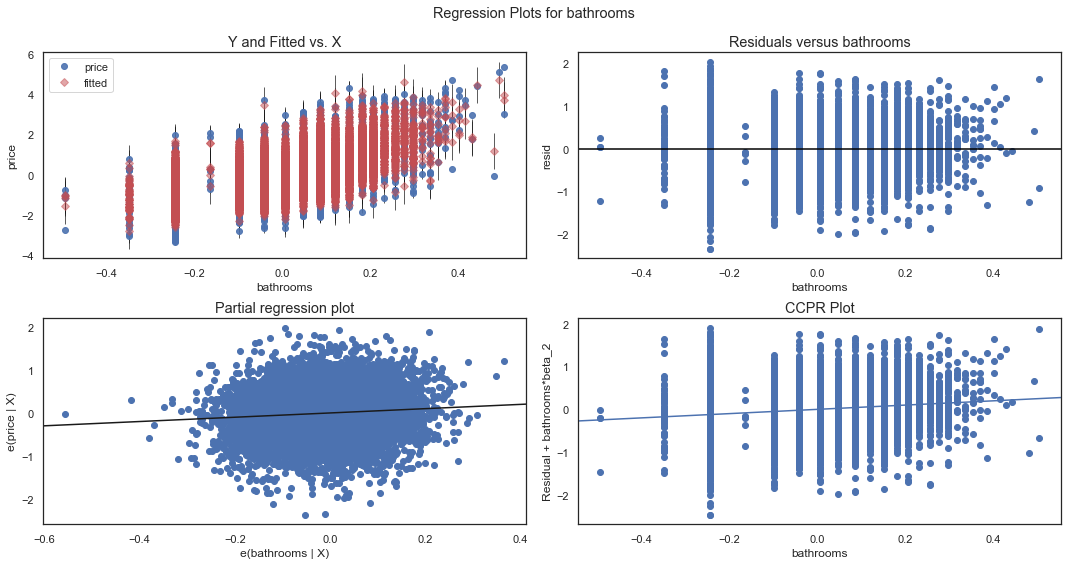

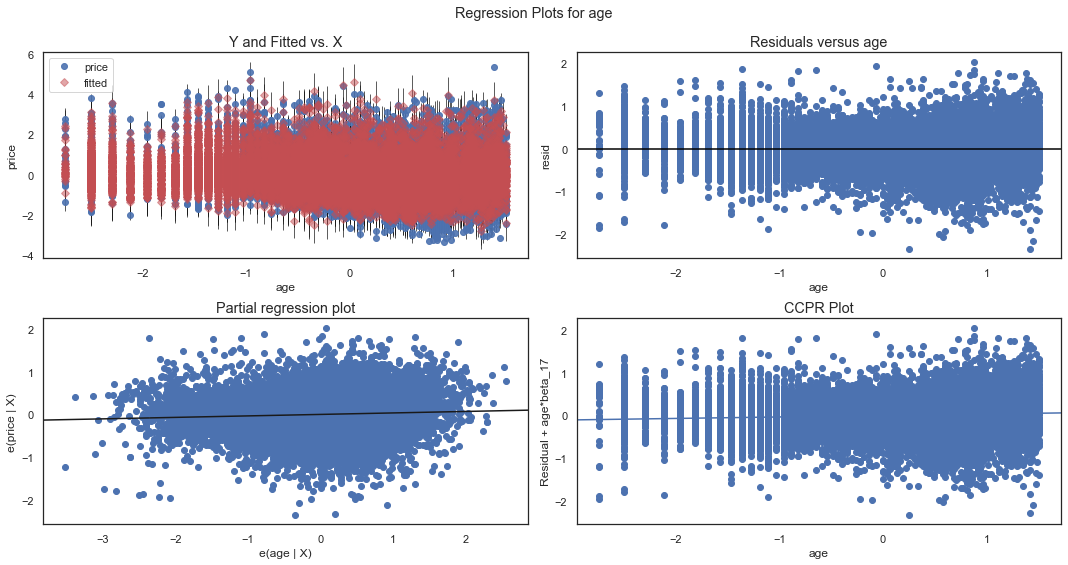

In [107]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','dist_from_top','sqft_lot15','sqft_living15','bedrooms','bathrooms','age']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [108]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 560.5840460225272),
 ('Prob', 1.865181437730042e-122),
 ('Skew', -0.08996745365456453),
 ('Kurtosis', 3.863914102851261)]

### Trial 4 Discussion:
This didn't really produce much better results but those variable will be dropped as their p value was too high. The next point of contention is working to increase the normality of the model. Let's first examine the predictors latitude. 

In [109]:
df.drop(['floors','long','sqft_lot','zipcode'],axis=1,inplace=True)
df.head()

price  bedrooms  bathrooms  sqft_above  sqft_basement      lat  \
0 -1.401998 -0.022653  -0.244401   -0.753565      -0.798211  47.5112   
1  0.279938 -0.022653   0.048081    0.672693       1.092003  47.7210   
2 -1.799430 -0.138616  -0.244401   -1.752954      -0.798211  47.7379   
3  0.499698  0.059624   0.151840   -1.026835       1.350776  47.5208   
4  0.178434 -0.022653   0.005599    0.073515      -0.798211  47.6168   

   sqft_living15  sqft_lot15  dist_from_top  condition_(2, 5]  view_(0, 3]  \
0      -1.035429   -0.260621      -0.620617                 1            0   
1      -0.326781   -0.187695      -0.039721                 1            0   
2       1.126504   -0.172186       0.034583                 1            0   
3      -0.990187   -0.284453       0.000914                 1            0   
4      -0.134218   -0.192682       0.003028                 1            0   

   view_(3, 4]  waterfront_1.0  grade_(6, 9]  grade_(9, 13]  Renovated?_True  \
0            0               0             1              0                0   
1            0               0             1              0                1   
2            0               0             0              0                0   
3            0               0             1              0                0   
4            0               0             1              0                0   

   prime_zipcode_True       age  
0                   0  0.687861  
1                   0  0.767756  
2                   0  1.077870  
3                   0  0.464369  
4                   0 -0.219034

## Trial 5: Latitude and Age investigation. 

* Categorical predictors: view (binned), waterfront, grade (binned), condition (binned), renovated? 
* Quantitative predictors: bedrooms, bathrooms, sqft_above, sqft_living15, sqft_living, dist_from_top
* Notes: Dropped lat and age

Let's first look at the histogram for latitude.

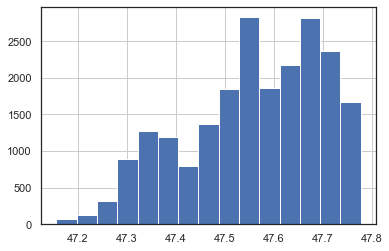

In [110]:
df.lat.hist(bins=15)

Let's try to improve this distribution by standardizing and log transforming the predictor lat.

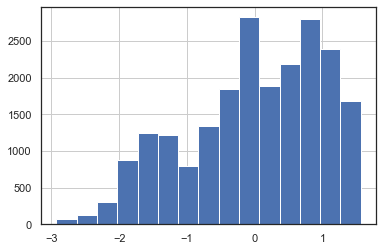

In [111]:
df.lat=np.log(df.lat)
df.lat=(df.lat-df.lat.mean())/df.lat.std()
df.lat.hist(bins=15)

This didn't really improve the distribution of the predictor to be more normal. Thus even though the predictor lat is a key predictor as seen by its coefficient, it might be best to drop the variable in order to improve on normality. Let's next look at the linearity between the newly introduced age variable and price. 

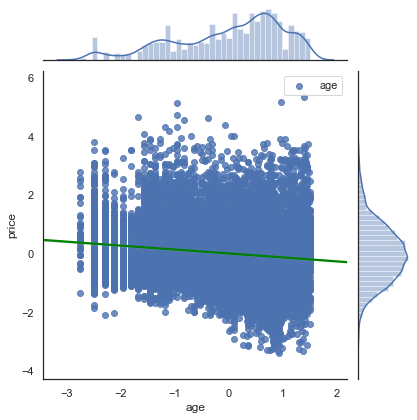

In [112]:
sns.jointplot(x='age', y="price",
                  data=df, 
                  kind='reg', 
                  label=col,
                  joint_kws={'line_kws':{'color':'green'}})
#     sns.regplot(walmart[column], walmart.Weekly_Sales, label=column)
plt.legend()
plt.show()

This joint plot shows a slightly negative linear relationship between price and age however due to its lack of normality and minimal relationship the age variable will be dropped. 

In [113]:
x=df.drop(['price','lat','age'],axis=1)
y=df.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [114]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     3332.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:07:20   Log-Likelihood:                -12795.
No. Observations:               17277   AIC:                         2.562e+04
Df Residuals:                   17261   BIC:                         2.575e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7087      0.041    -17.126      0.000      -0.790      -0.628
bedrooms              -0.8955      0.063    -14.299      0.000      -1.018      -0.773
bathrooms              0.2923      0.043      6.767      0.000       0.208       0.377
sqft_above             0.4379      0.008     52.562      0.000       0.422       0.454
sqft_basement          0.1739      0.005     34.158      0.000       0.164       0.184
sqft_living15          0.1440      0.006     23.848      0.000       0.132       0.156
sqft_lot15             0.0622      0.004     14.984      0.000       0.054       0.070
dist_from_top         -0.4389      0.005    -95.061      0.000      -0.448      -0.430
condition_(2, 5]       0.4147      0.040     10.251      0.000       0.335       0.494
view_(0, 3]            0.2802      0.015     19.014      0.000       0.251       0.309
view_(3, 4]            0.6677      0.039     16.998      0.000       0.591       0.745
waterfront_1.0         0.6328      0.057     11.077      0.000       0.521       0.745
grade_(6, 9]           0.2464      0.015     16.976      0.000       0.218       0.275
grade_(9, 13]          0.6576      0.024     27.320      0.000       0.610       0.705
Renovated?_True        0.1832      0.021      8.620      0.000       0.142       0.225
prime_zipcode_True     0.1089      0.022      4.888      0.000       0.065       0.153
==============================================================================
Omnibus:                      171.120   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.360
Skew:                          -0.148   Prob(JB):                     7.02e-50
Kurtosis:                       3.476   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.25749437979329326
Test Mean Squarred Error: 0.2632460763312019


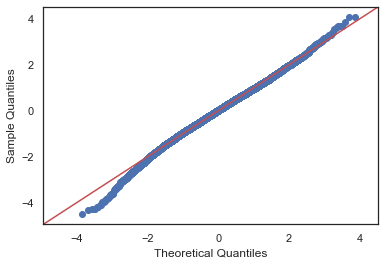

In [116]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

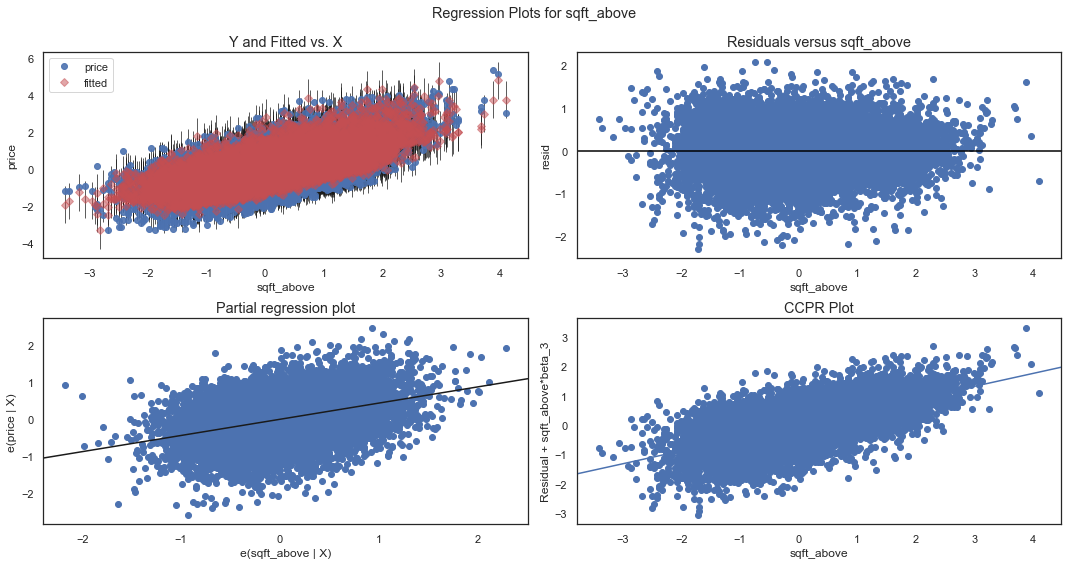

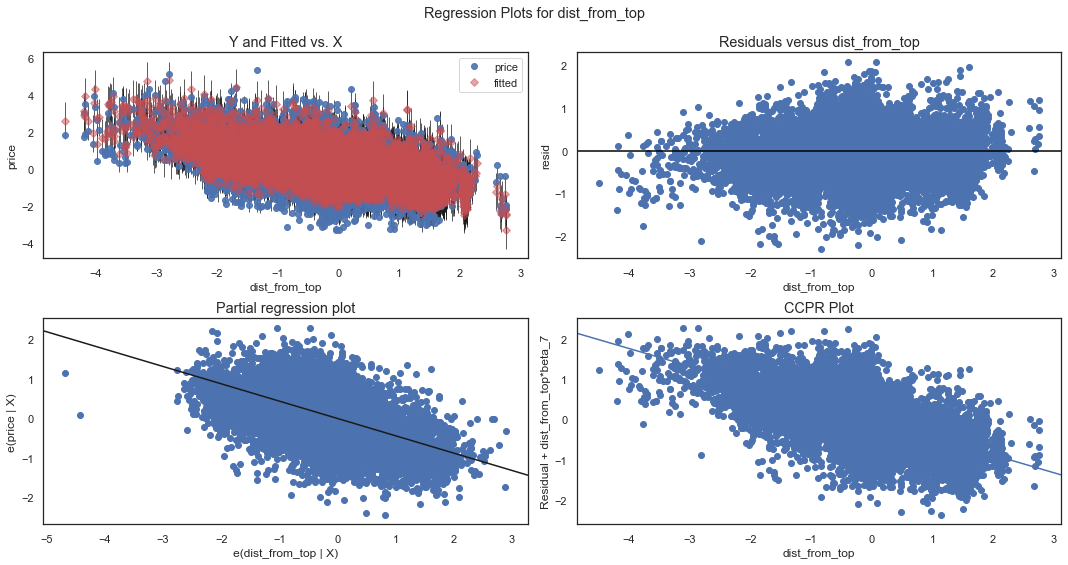

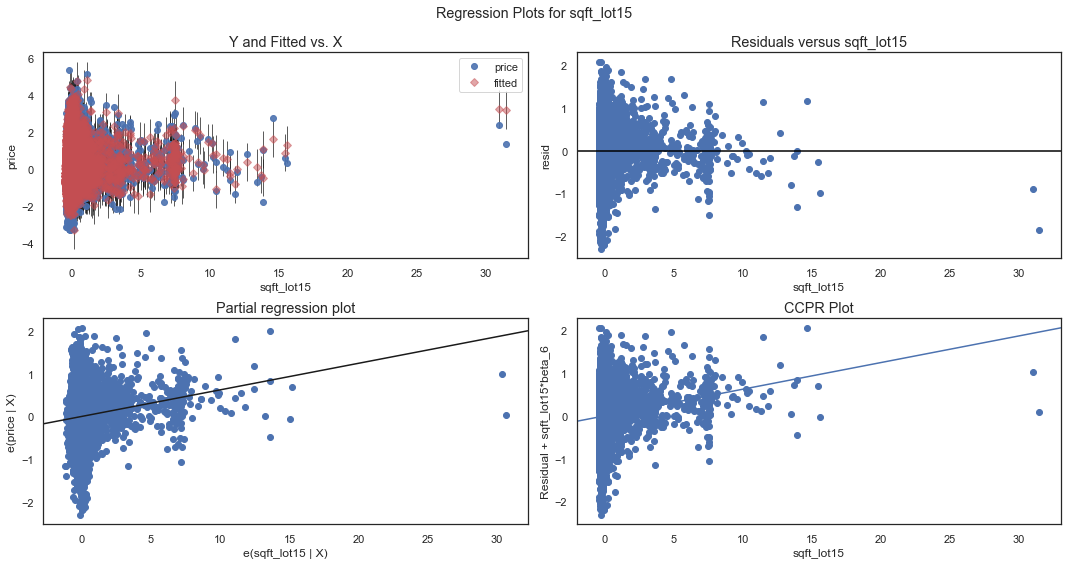

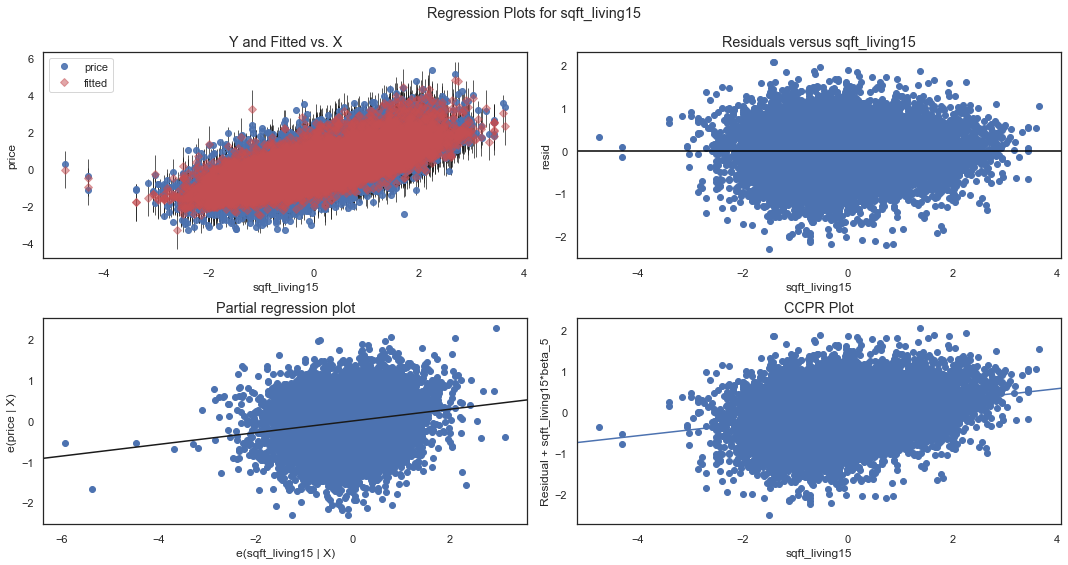

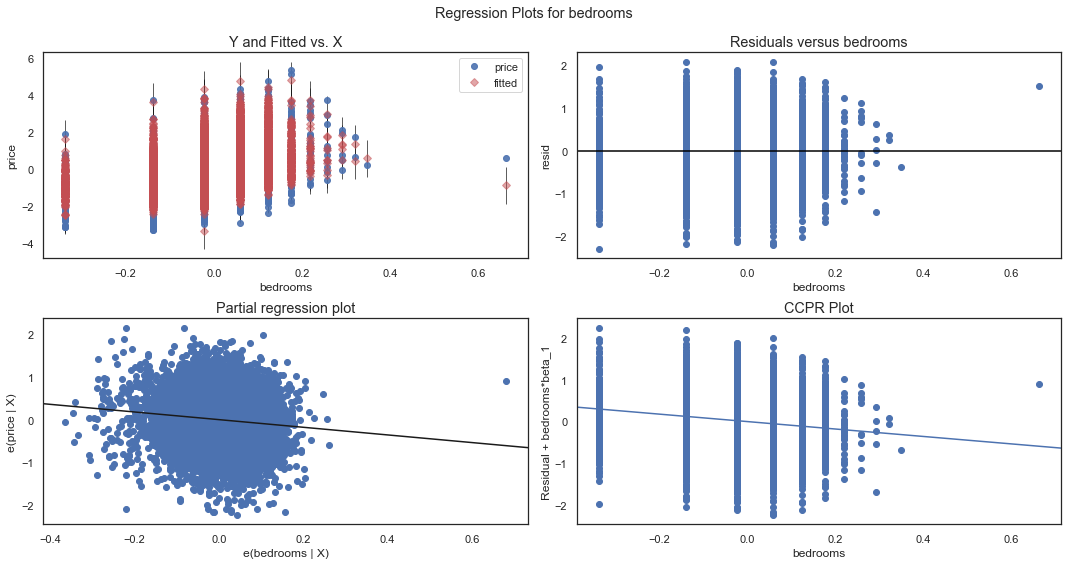

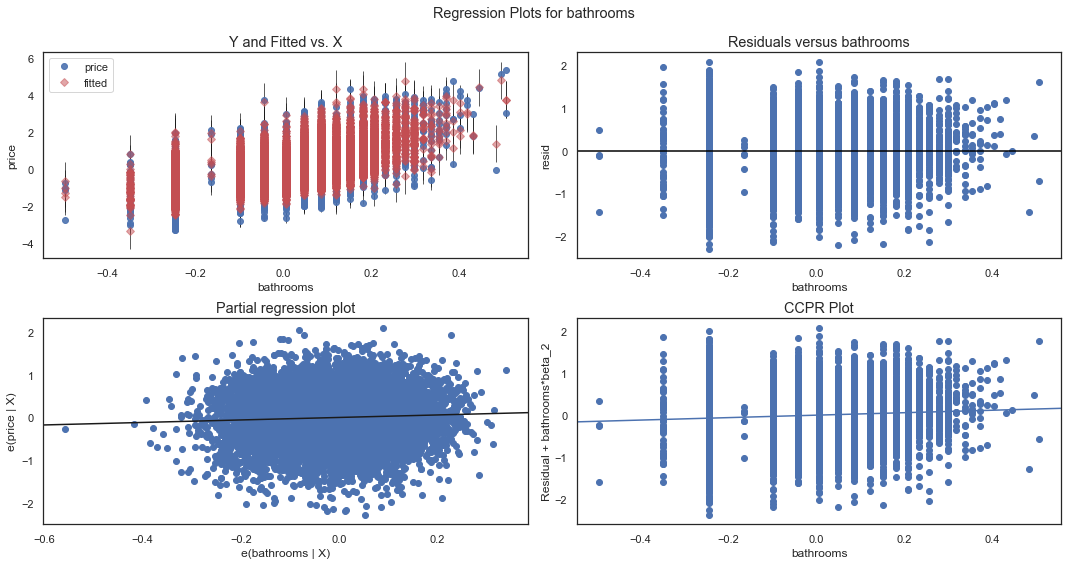

In [117]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','dist_from_top','sqft_lot15','sqft_living15','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [118]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 226.3596181143674),
 ('Prob', 7.024791903606069e-50),
 ('Skew', -0.147955505550869),
 ('Kurtosis', 3.47631882472849)]

### Trial 5 Discussion:

Dropping latitude and age from the model helped to significantly improve the normality of the model while still maintaining a relatively reasonable R-squared value. Thus these variables will stay dropped 

In [119]:
df.drop(['lat','age'],axis=1, inplace=True)

## Trial 6:  Stepwise Selection

* Categorical predictors: view (binned), waterfront, grade (binned), condition (binned), renovated? 
* Quantitative predictors: bedrooms, bathrooms, sqft_above, sqft_living15, sqft_living, dist_from_top
* Notes: performed stepwise selection to see if any predictors can be eliminated.

Let's first introduce the stepwise selection function then run our dataset into it. 

In [120]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [121]:
result = stepwise_selection(x, y, verbose = True)
print('resulting features:')
print(result)

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/ana

Add  view_(0, 3]                    with p-value 0.0
Add  dist_from_top                  with p-value 0.0
Add  grade_(9, 13]                  with p-value 0.0
Add  grade_(6, 9]                   with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  view_(3, 4]                    with p-value 1.46236e-218
Add  sqft_lot15                     with p-value 2.73178e-68
Add  bedrooms                       with p-value 6.20571e-57
Add  waterfront_1.0                 with p-value 3.08791e-40
Add  condition_(2, 5]               with p-value 5.85303e-30
Add  Renovated?_True                with p-value 2.71914e-23
Add  bathrooms                      with p-value 2.43744e-11
Add  prime_zipcode_True             with p-value 3.22714e-07
resulting features:
['view_(0, 3]', 'dist_from_top', 'grade_(9, 13]', 'grade_(6, 9]', 'sqft_living15', 'sqft_above', 'sqft_basement', 'view_

In [122]:
resulting_features=['sqft_above', 'sqft_living15', 'sqft_basement', 'dist_from_top', 'view_(3, 4]', 'grade_(9, 13]', 'view_(0, 3]', 'grade_(6, 9]', 'sqft_lot15', 'bedrooms', 'waterfront_1.0', 'condition_(2, 5]', 'Renovated?_True', 'bathrooms', 'prime_zipcode_True']

In [123]:
len(resulting_features)

15

Let's now incorporate the resulting features into dataset by dropping any column that is not in the variable resulting features. 

In [124]:
for column in x:
    if (column  not in resulting_features):
        x.drop(column,axis=1,inplace=True)
x.head()

bedrooms  bathrooms  sqft_above  sqft_basement  sqft_living15  sqft_lot15  \
0 -0.022653  -0.244401   -0.753565      -0.798211      -1.035429   -0.260621   
1 -0.022653   0.048081    0.672693       1.092003      -0.326781   -0.187695   
2 -0.138616  -0.244401   -1.752954      -0.798211       1.126504   -0.172186   
3  0.059624   0.151840   -1.026835       1.350776      -0.990187   -0.284453   
4 -0.022653   0.005599    0.073515      -0.798211      -0.134218   -0.192682   

   dist_from_top  condition_(2, 5]  view_(0, 3]  view_(3, 4]  waterfront_1.0  \
0      -0.620617                 1            0            0               0   
1      -0.039721                 1            0            0               0   
2       0.034583                 1            0            0               0   
3       0.000914                 1            0            0               0   
4       0.003028                 1            0            0               0   

   grade_(6, 9]  grade_(9, 13]  Renovated?_True  prime_zipcode_True  
0             1              0                0                   0  
1             1              0                1                   0  
2             0              0                0                   0  
3             1              0                0                   0  
4             1              0                0                   0

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [126]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     3332.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:07:32   Log-Likelihood:                -12795.
No. Observations:               17277   AIC:                         2.562e+04
Df Residuals:                   17261   BIC:                         2.575e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7087      0.041    -17.126      0.000      -0.790      -0.628
bedrooms              -0.8955      0.063    -14.299      0.000      -1.018      -0.773
bathrooms              0.2923      0.043      6.767      0.000       0.208       0.377
sqft_above             0.4379      0.008     52.562      0.000       0.422       0.454
sqft_basement          0.1739      0.005     34.158      0.000       0.164       0.184
sqft_living15          0.1440      0.006     23.848      0.000       0.132       0.156
sqft_lot15             0.0622      0.004     14.984      0.000       0.054       0.070
dist_from_top         -0.4389      0.005    -95.061      0.000      -0.448      -0.430
condition_(2, 5]       0.4147      0.040     10.251      0.000       0.335       0.494
view_(0, 3]            0.2802      0.015     19.014      0.000       0.251       0.309
view_(3, 4]            0.6677      0.039     16.998      0.000       0.591       0.745
waterfront_1.0         0.6328      0.057     11.077      0.000       0.521       0.745
grade_(6, 9]           0.2464      0.015     16.976      0.000       0.218       0.275
grade_(9, 13]          0.6576      0.024     27.320      0.000       0.610       0.705
Renovated?_True        0.1832      0.021      8.620      0.000       0.142       0.225
prime_zipcode_True     0.1089      0.022      4.888      0.000       0.065       0.153
==============================================================================
Omnibus:                      171.120   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.360
Skew:                          -0.148   Prob(JB):                     7.02e-50
Kurtosis:                       3.476   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [128]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.25749437979329326
Test Mean Squarred Error: 0.2632460763312019


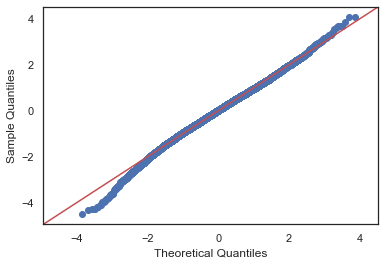

In [129]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

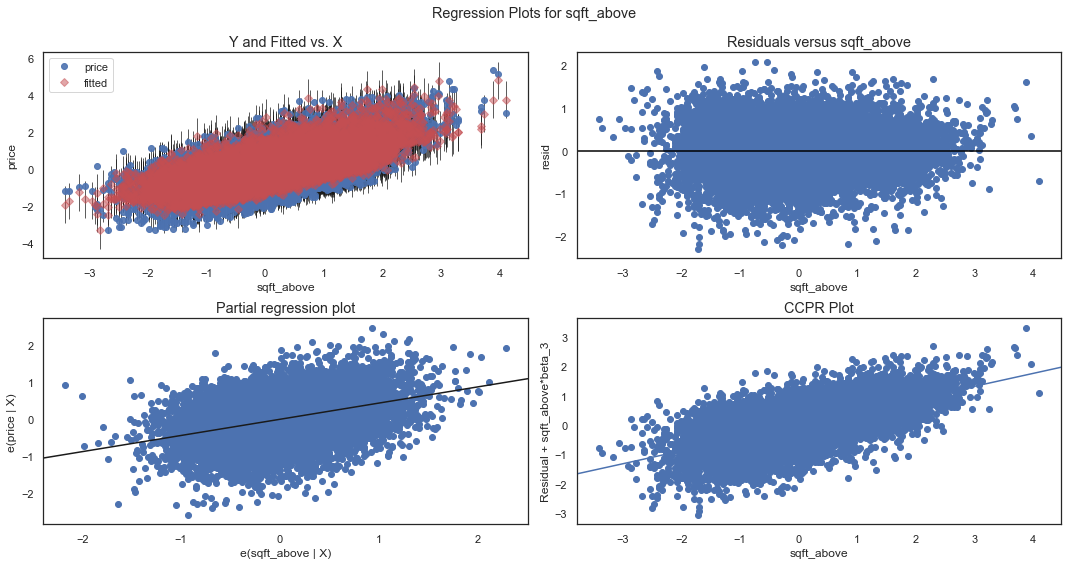

In [130]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_above", fig=fig)
plt.show()

In [131]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 226.3596181143674),
 ('Prob', 7.024791903606069e-50),
 ('Skew', -0.147955505550869),
 ('Kurtosis', 3.47631882472849)]

### Trial 6 Discussion:

The stepwise selection function picked every variable already in the model thus there was no difference in terms of results. Thus let's next try to select features using Recursive Feature Elimination from Scikit.

Trial 7

In [147]:
predictors_int = sm.add_constant(x)
model = sm.OLS(df['price'],predictors_int).fit()
model.summary()


linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 1)
selector = selector.fit(x, df["price"])

test=x.columns[selector.support_]
print(test)
selector.ranking_

Index(['bathrooms'], dtype='object')


/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


array([10,  1,  8,  7,  6,  4,  3,  5,  9,  2])

In [133]:
rfe_results=['bedrooms', 'bathrooms', 'sqft_above', 'dist_from_top',
       'condition_(2, 5]', 'view_(0, 3]', 'view_(3, 4]', 'waterfront_1.0',
       'grade_(6, 9]', 'grade_(9, 13]']

In [134]:
for column in x:
    if (column  not in rfe_results):
        x.drop(column,axis=1,inplace=True)
x.head()

bedrooms  bathrooms  sqft_above  dist_from_top  condition_(2, 5]  \
0 -0.022653  -0.244401   -0.753565      -0.620617                 1   
1 -0.022653   0.048081    0.672693      -0.039721                 1   
2 -0.138616  -0.244401   -1.752954       0.034583                 1   
3  0.059624   0.151840   -1.026835       0.000914                 1   
4 -0.022653   0.005599    0.073515       0.003028                 1   

   view_(0, 3]  view_(3, 4]  waterfront_1.0  grade_(6, 9]  grade_(9, 13]  
0            0            0               0             1              0  
1            0            0               0             1              0  
2            0            0               0             0              0  
3            0            0               0             1              0  
4            0            0               0             1              0

In [135]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [136]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     4073.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:07:33   Log-Likelihood:                -14075.
No. Observations:               17277   AIC:                         2.817e+04
Df Residuals:                   17266   BIC:                         2.826e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7700      0.044    -17.322      0.000      -0.857      -0.683
bedrooms            -0.2481      0.064     -3.871      0.000      -0.374      -0.122
bathrooms            0.9285      0.043     21.431      0.000       0.844       1.013
sqft_above           0.3942      0.007     60.336      0.000       0.381       0.407
dist_from_top       -0.4709      0.004   -110.911      0.000      -0.479      -0.463
condition_(2, 5]     0.3734      0.044      8.576      0.000       0.288       0.459
view_(0, 3]          0.4670      0.015     30.408      0.000       0.437       0.497
view_(3, 4]          0.9013      0.042     21.504      0.000       0.819       0.983
waterfront_1.0       0.6517      0.061     10.605      0.000       0.531       0.772
grade_(6, 9]         0.3368      0.015     21.804      0.000       0.306       0.367
grade_(9, 13]        0.9075      0.025     35.898      0.000       0.858       0.957
==============================================================================
Omnibus:                      107.497   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.767
Skew:                          -0.105   Prob(JB):                     1.21e-30
Kurtosis:                       3.384   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [138]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.2986491019889896
Test Mean Squarred Error: 0.30693888215719906


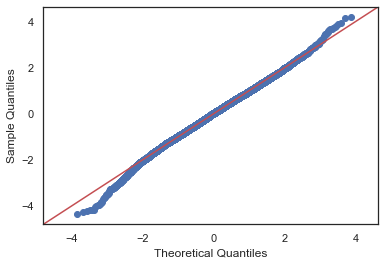

In [139]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

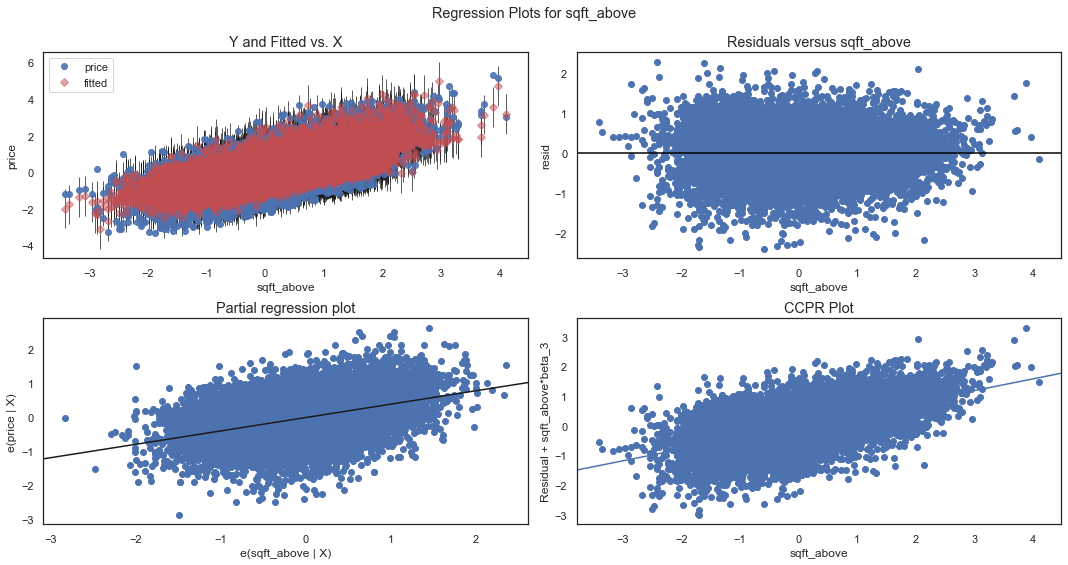

In [140]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_above", fig=fig)
plt.show()

In [141]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 137.7671030133879),
 ('Prob', 1.2140978407974692e-30),
 ('Skew', -0.1048934999116286),
 ('Kurtosis', 3.383882584143149)]

In [142]:
model.params

const              -0.769987
bedrooms           -0.248104
bathrooms           0.928518
sqft_above          0.394189
dist_from_top      -0.470855
condition_(2, 5]    0.373364
view_(0, 3]         0.466959
view_(3, 4]         0.901284
waterfront_1.0      0.651681
grade_(6, 9]        0.336761
grade_(9, 13]       0.907466
dtype: float64

In [143]:
ranking = model.params.drop(['const']).abs().sort_values(ascending=True)

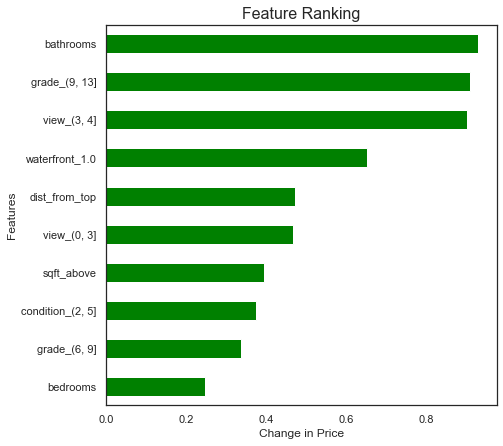

In [144]:

ranking.plot(kind='barh' , color='green', figsize=(7,7));
plt.title('Feature Ranking', fontsize=16);
plt.xlabel("Change in Price");
plt.ylabel("Features");
plt.savefig('ranking.jpg', bbox_inches='tight')

In [145]:
from sklearn.model_selection import cross_val_score

cv_5_results = (cross_val_score(linreg, x, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = (cross_val_score(linreg, x, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = (cross_val_score(linreg, x, y, cv=20, scoring="neg_mean_squared_error"))


In [146]:
print(np.mean(cv_5_results))
print(np.mean(cv_10_results))
print(np.mean(cv_20_results))

-0.3011843198871255
-0.30139051701253916
-0.30100660523601724
